In [1]:
# 整理用
gsheet_id = '1TMDwDBPH4UWz0LiMV9PUSOVQtasLYykNMkhWJrxQcq0'
gsheet_name2 = '自然人-Binary-1監護宣告'
gsheet_name3 = '自然人-Binary-2輔助宣告'
gsheet_name = gsheet_name2

# Setup (1~3)


In [2]:
import gspread
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import auth
from google.auth import default
from statsmodels.graphics.mosaicplot import mosaic
from scipy import stats
from sklearn.decomposition import PCA


class Analysis():

  def __init__(self, sheet_id, sheet_name, auto_proc=True, to_drop=[]):
    auth.authenticate_user()
    creds, _ = default()
    gc = gspread.authorize(creds)
    self.wb = gc.open_by_key(sheet_id)
    sheet = self.wb.worksheet(sheet_name)
    self.data = sheet.get_all_values()
    self.df = self.load_df(self.data)
    self.df_full = None
    self.set_zh_font()
    if auto_proc:
      self.drop(to_drop)
      
  def load_df(self, data):
    df = pd.DataFrame(data)
    df.columns = df.loc[0, :].values.tolist()  # gsheet 預設欄位是數字 所以把第一行換成欄位/變數名
    df = df.drop([0]).reset_index(drop=True)  # 去除一行多的東西 這個不一定要做 看你自己的資料 
    return df

  def write_back_to_sheet(self, sheet_name):
    sheet = self.wb.worksheet(sheet_name)
    sheet.update([self.df.columns.values.tolist()] + self.df.values.tolist())

  def info(self):
    self.df.info()

  def describe(self):
    self.df.describe()

  def cols(self):
    return self.df.columns.to_list()

  def print_cols(self):
    for i, c in enumerate(self.cols()):
      print(i, c)

  def col(self, idx):
    col = self.cols()[idx]
    print(idx, col)
    return col

  def drop(self, columns_array):
    self.df_full = self.df.copy(deep=True)
    self.df = self.df.drop(columns_array, axis=1)

  def replace_col_to(self, col, target, to):
    self.df[col] = self.df[col].apply(
      lambda x: to if x == target else x)

  def replace_col_to_NaN(self, col, target):
    self.df[col] = self.df[col].apply(
      lambda x: np.nan if x == target else x)
  
  def replace_col_to_zero(self, col, target):
    self.df[col] = self.df[col].apply(
      lambda x: 0 if x == target else x)

  def replace_all_col_to_NaN(self, target):
    for col in self.df.columns:
      self.replace_col_to_NaN(col, target)

  def binary_converter(self, col):
    # convert 1/2 binary to 1/0
    # 1 = Yes
    # 2 = No (should be 0)
    self.df[col] = self.df[col].apply(lambda x: 0 if x == 2 else x)

  def print_value_counts(self):
    print(len(self.df.columns))
    print(self.df.columns)
    for i in self.df.columns:
      print(i)
      print(self.df[i].value_counts())
      print("-"*50)

  def convert_to_numeric(self):
    for i in range(0, len(self.df.columns)):
      self.df.iloc[:,i] = pd.to_numeric(
        self.df.iloc[:,i], errors='coerce')

  def print_dtypes(self):
    print(self.df.dtypes)

  def set_zh_font(self):
    #fm.fontManager.ttflist += fm.createFontList(['regular.ttf'])
    fm.fontManager.addfont('regular.ttf')
    matplotlib.rc('font', family='Noto Sans TC')

  def banner(self, a, b):
    print("-"*50)
    print(f"X 軸 = {a}")
    print(f"Y 軸 = {b}")
    print("-"*50)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# download font
![ ! -f regular.ttf ] && wget http://qinghe.com.tw/fonts/Noto%20Sans%20TC/regular.ttf

--2022-05-22 12:01:23--  http://qinghe.com.tw/fonts/Noto%20Sans%20TC/regular.ttf
Resolving qinghe.com.tw (qinghe.com.tw)... 128.199.134.179
Connecting to qinghe.com.tw (qinghe.com.tw)|128.199.134.179|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5641188 (5.4M)
Saving to: ‘regular.ttf’

regular.ttf         100%[===================>]   5.38M   799KB/s    in 11s     

2022-05-22 12:01:35 (502 KB/s) - ‘regular.ttf’ saved [5641188/5641188]



In [4]:
a = Analysis(gsheet_id, gsheet_name, to_drop=[
  'index',
  'UUID',
  '主管機關是否被法院改定 (1=是, 2=否)',
  '宣告性質',
  '原監護輔助人之類型'
])
a.convert_to_numeric()
a.df = a.df[(a.df['聲因1'] == 1) & (a.df['聲因2'] == 1)]

In [5]:
a.print_cols()

0 聲因1
1 聲因2
2 聲因3
3 聲因4
4 聲因5
5 聲因6
6 聲因7
7 聲因8
8 聲因9
9 原監護輔助人之人數（自然人）
10 法院是否於聲請原因外考量「其他改定因素」
11 法院是否認為原監護輔助人「年事已高」
12 法院是否考慮原監護輔助人之身體狀況
13 法院是否認為原監護輔助人「身體不堪負荷」
14 法院是否認為原監護輔助人「盜領存款」
15 法院是否認為原監護輔助人「不當處理本人之不動產」
16 法院是否認為原監護輔助人「與本人有利害關係」
17 法院是否認為原監護輔助人有「其他不當行為」
18 法院是否認為原監護輔助人是「本人之實際照顧者」
19 法院是否認為監護人現為本人廣義照顧者
20 原監護輔助人是否有意願續任
21 專業人士訪視報告之「改定建議」
22 本人之「改定建議」
23 其他親屬、關係人之「改定建議」
24 原監護輔助人是否被法院改定


In [6]:
a.print_value_counts()

25
Index(['聲因1', '聲因2', '聲因3', '聲因4', '聲因5', '聲因6', '聲因7', '聲因8', '聲因9',
       '原監護輔助人之人數（自然人）', '法院是否於聲請原因外考量「其他改定因素」', '法院是否認為原監護輔助人「年事已高」',
       '法院是否考慮原監護輔助人之身體狀況', '法院是否認為原監護輔助人「身體不堪負荷」', '法院是否認為原監護輔助人「盜領存款」',
       '法院是否認為原監護輔助人「不當處理本人之不動產」', '法院是否認為原監護輔助人「與本人有利害關係」',
       '法院是否認為原監護輔助人有「其他不當行為」', '法院是否認為原監護輔助人是「本人之實際照顧者」',
       '法院是否認為監護人現為本人廣義照顧者', '原監護輔助人是否有意願續任', '專業人士訪視報告之「改定建議」', '本人之「改定建議」',
       '其他親屬、關係人之「改定建議」', '原監護輔助人是否被法院改定'],
      dtype='object')
聲因1
1    27
Name: 聲因1, dtype: int64
--------------------------------------------------
聲因2
1    27
Name: 聲因2, dtype: int64
--------------------------------------------------
聲因3
0    27
Name: 聲因3, dtype: int64
--------------------------------------------------
聲因4
0    26
1     1
Name: 聲因4, dtype: int64
--------------------------------------------------
聲因5
0    26
1     1
Name: 聲因5, dtype: int64
--------------------------------------------------
聲因6
0    22
1     5
Name: 聲因6, dtype: int64
-----------------------

# 4. 檢查共線性/相關性

In [7]:
class Corr(Analysis):

  def corr_heatmap(self):
    """4.1"""
    ## 檢查共線性
    colormap = plt.cm.viridis
    plt.figure(figsize=(20,16))
    plt.title('all corelations', y=1.05, size=15)
    corr = self.df.corr()
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    with sns.axes_style("white"):
      sns.heatmap(corr, linewidths=0.1, vmax=1.0,
                  square=True, cmap="YlGnBu",
                  linecolor='white', annot=True, mask=mask)

  def chi2_contingency_and_mosaic(self, column_a, column_b):
    """4.2"""
    self.banner(column_a, column_b)
    crosstable = pd.crosstab(
        self.df[column_a],
        self.df[column_b])
    stat, p, dof, expected = stats.chi2_contingency(crosstable, correction=False)
    print(crosstable)
    # interpret p-value
    alpha = 0.05
    print("p value is " + str(p))
    if p <= alpha:
        print('兩者有關 Dependent (reject H0)')
    else:
        print('兩者無關 Independent (H0 holds true)')
    mosaic(self.df, [column_a, column_b])
    plt.show()

  def pca(self):
    """4.3.1"""
    # You must normalize the data before applying the fit method
    df_normalized=(self.df - self.df.mean()) / self.df.std()
    pca = PCA(n_components=self.df.shape[1])
    pca.fit(df_normalized)

    # Reformat and view results
    loadings = pd.DataFrame(
        pca.components_.T,
      columns=['PC%s' % _ for _ in range(len(df_normalized.columns))],
      index=self.df.columns)
    print(loadings)

    plt.plot(pca.explained_variance_ratio_)
    plt.ylabel('Explained Variance')
    plt.xlabel('Components')
    plt.show()

  def pca2(self, column_b, column_a):
    """4.3.2"""
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(self.df)
    principalDf = pd.DataFrame(data=principalComponents, columns=[column_a, column_b])
    finalDf = principalDf
    print(finalDf.head())

    fig = plt.figure(figsize = (12,12))
    ax = fig.add_subplot(1,1,1)
    sns.scatterplot(x=column_a, y=column_b, data=finalDf)
    plt.show()

## 4.1 所有相關/共線性

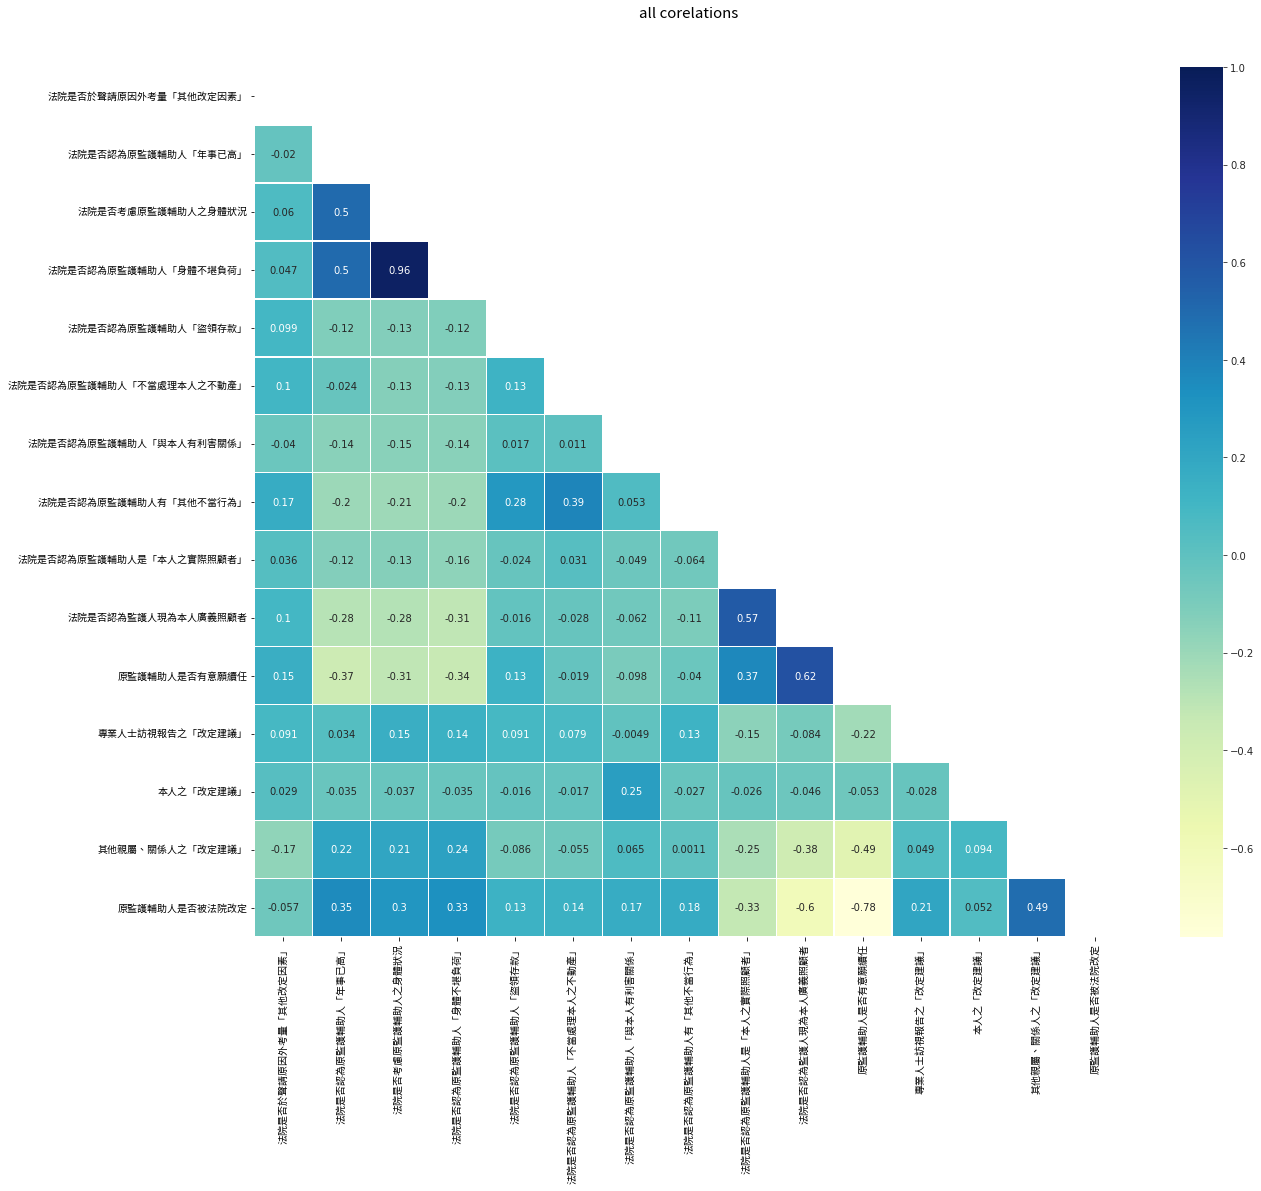

In [8]:
c = Corr(gsheet_id, gsheet_name, to_drop=[
  'index',
  'UUID',
  '聲因1',
  '聲因2',
  '聲因3',
  '聲因4',
  '聲因5',
  '聲因6',
  '聲因7',
  '聲因8',
  '聲因9',
  '宣告性質',
  '原監護輔助人之類型',
  '原監護輔助人之人數（自然人）',
  '主管機關是否被法院改定 (1=是, 2=否)',
  #'法院是否於聲請原因外考量「其他改定因素」',
  #'法院是否認為原監護輔助人「年事已高」',
  #'法院是否考慮原監護輔助人之身體狀況',
  #'法院是否認為原監護輔助人「身體不堪負荷」',
  #'法院是否認為原監護輔助人「盜領存款」',
  #'法院是否認為原監護輔助人「不當處理本人之不動產」',
  #'原監護輔助人是否與本人有「利害關係」',
  #'法院是否認為原監護輔助人有「其他不當行為」',
  #'法院是否認為原監護輔助人是「本人之實際照顧者」',
  #'監護輔助人是否為本人「廣義照顧者」',
  #'原監護輔助人是否有意願續任',
  #'專業人士訪視報告之「改定建議」',
  #'本人之「改定建議」',
  #'其他親屬、關係人之「改定建議」',
  #'原監護輔助人是否被法院改定',
])
for col in c.df.columns:
  c.replace_col_to(col, '', 0)
c.convert_to_numeric()
c.corr_heatmap()

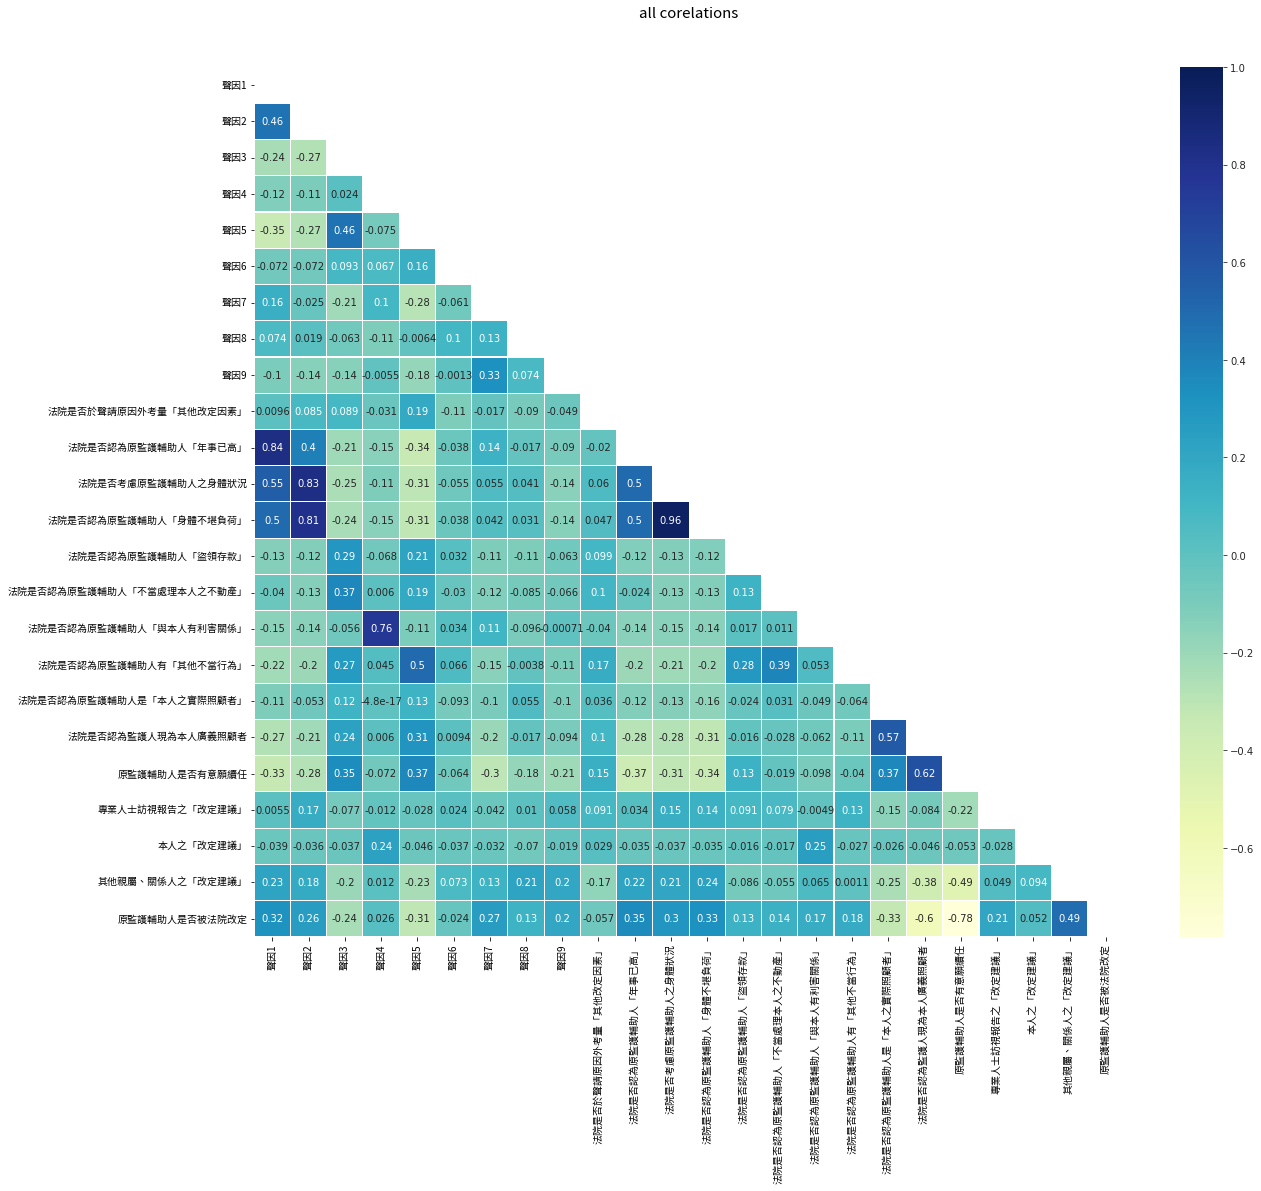

In [9]:
c2 = Corr(gsheet_id, gsheet_name, to_drop=[
  'index',
  'UUID',
  '宣告性質',
  '原監護輔助人之類型',
  '原監護輔助人之人數（自然人）',
  '主管機關是否被法院改定 (1=是, 2=否)',
  #'法院是否於聲請原因外考量「其他改定因素」',
  #'法院是否認為原監護輔助人「年事已高」',
  #'法院是否考慮原監護輔助人之身體狀況',
  #'法院是否認為原監護輔助人「身體不堪負荷」',
  #'法院是否認為原監護輔助人「盜領存款」',
  #'法院是否認為原監護輔助人「不當處理本人之不動產」',
  #'原監護輔助人是否與本人有「利害關係」',
  #'法院是否認為原監護輔助人有「其他不當行為」',
  #'法院是否認為原監護輔助人是「本人之實際照顧者」',
  #'監護輔助人是否為本人「廣義照顧者」',
  #'原監護輔助人是否有意願續任',
  #'專業人士訪視報告之「改定建議」',
  #'本人之「改定建議」',
  #'其他親屬、關係人之「改定建議」',
  #'原監護輔助人是否被法院改定',
])
for col in c2.df.columns:
  c2.replace_col_to(col, '', 0)
c2.convert_to_numeric()
c2.corr_heatmap()

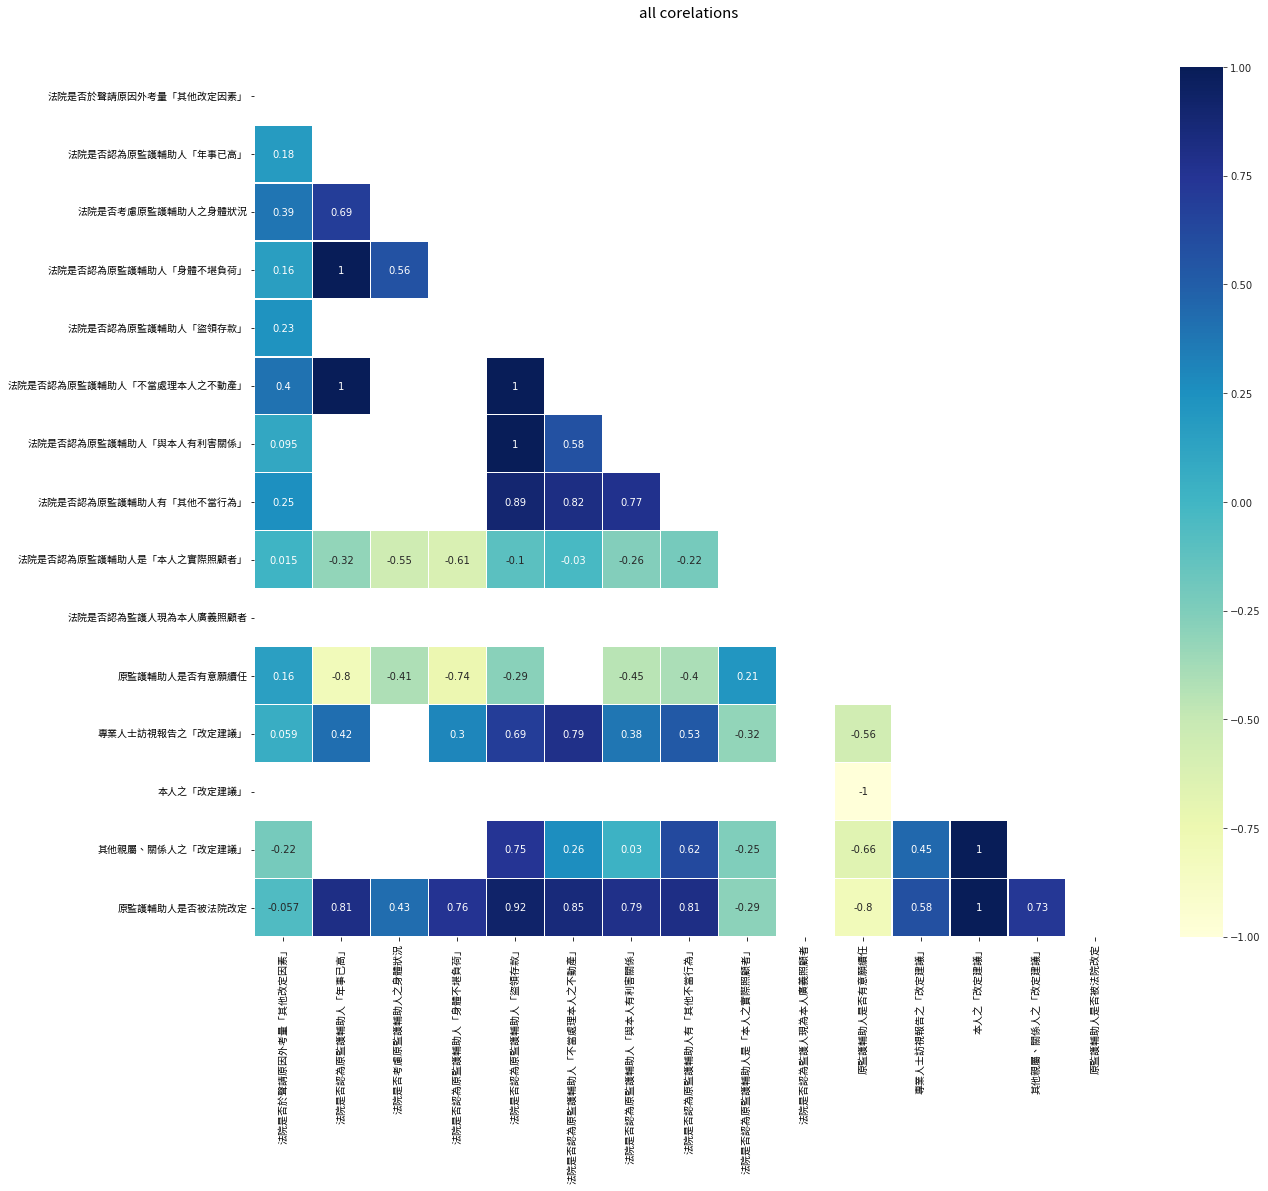

In [10]:
c = Corr(gsheet_id, gsheet_name, to_drop=[
  'index',
  'UUID',
  '聲因1',
  '聲因2',
  '聲因3',
  '聲因4',
  '聲因5',
  '聲因6',
  '聲因7',
  '聲因8',
  '聲因9',
  '宣告性質',
  '原監護輔助人之類型',
  '原監護輔助人之人數（自然人）',
  '主管機關是否被法院改定 (1=是, 2=否)',
  #'法院是否於聲請原因外考量「其他改定因素」',
  #'法院是否認為原監護輔助人「年事已高」',
  #'法院是否考慮原監護輔助人之身體狀況',
  #'法院是否認為原監護輔助人「身體不堪負荷」',
  #'法院是否認為原監護輔助人「盜領存款」',
  #'法院是否認為原監護輔助人「不當處理本人之不動產」',
  #'原監護輔助人是否與本人有「利害關係」',
  #'法院是否認為原監護輔助人有「其他不當行為」',
  #'法院是否認為原監護輔助人是「本人之實際照顧者」',
  #'監護輔助人是否為本人「廣義照顧者」',
  #'原監護輔助人是否有意願續任',
  #'專業人士訪視報告之「改定建議」',
  #'本人之「改定建議」',
  #'其他親屬、關係人之「改定建議」',
  #'原監護輔助人是否被法院改定',
])
c.convert_to_numeric()
c.corr_heatmap()

## 4.2 兩兩相關性與馬賽克圖

--------------------------------------------------
X 軸 = 法院是否於聲請原因外考量「其他改定因素」
Y 軸 = 原監護輔助人是否被法院改定
--------------------------------------------------
原監護輔助人是否被法院改定          0    1
法院是否於聲請原因外考量「其他改定因素」         
0                      9   22
1                     65  112
p value is 0.4093128868094039
兩者無關 Independent (H0 holds true)


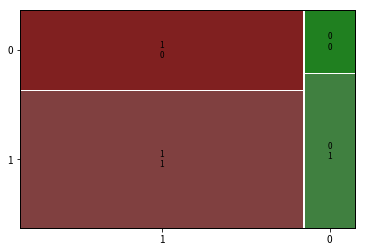

In [11]:
c.chi2_contingency_and_mosaic(c.cols()[0], '原監護輔助人是否被法院改定')

## 4.3 PCA

                    PC0       PC1       PC2       PC3       PC4       PC5  \
聲因1            0.408931 -0.352140 -0.103773  0.112488  0.196233  0.192992   
聲因2            0.350827 -0.472736 -0.036012  0.126900 -0.066500  0.094980   
聲因3           -0.416854 -0.024046 -0.109862  0.057779  0.464636  0.502103   
聲因4           -0.026615  0.263837  0.446286  0.671907  0.310606 -0.215645   
聲因5           -0.466965 -0.061504 -0.249676 -0.020805  0.160326  0.220285   
聲因6           -0.125897  0.092258 -0.442093  0.649863 -0.523982  0.107699   
聲因7            0.310775  0.458189 -0.016590 -0.015884  0.305786  0.068734   
聲因8            0.110039  0.125249 -0.702919 -0.017420  0.359843 -0.521345   
聲因9            0.164346  0.579242 -0.068354 -0.249650 -0.304089  0.300780   
原監護輔助人是否被法院改定  0.406957  0.094288 -0.140946  0.175525  0.170248  0.477499   

                    PC6       PC7       PC8       PC9  
聲因1            0.385772  0.151692 -0.270126  0.603985  
聲因2           -0.157105  0.444098  0.547

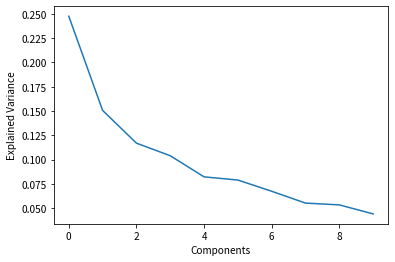

In [12]:
cc = Corr(gsheet_id, gsheet_name, to_drop=[
  'index',
  'UUID',
  #'聲因1',
  #'聲因2',
  #'聲因3',
  #'聲因4',
  #'聲因5',
  #'聲因6',
  #'聲因7',
  #'聲因8',
  #'聲因9',
  '宣告性質',
  '原監護輔助人之類型',
  '原監護輔助人之人數（自然人）',
  '主管機關是否被法院改定 (1=是, 2=否)',
  '法院是否於聲請原因外考量「其他改定因素」',
  '法院是否認為原監護輔助人「年事已高」',
  '法院是否考慮原監護輔助人之身體狀況',
  '法院是否認為原監護輔助人「身體不堪負荷」',
  '法院是否認為原監護輔助人「盜領存款」',
  '法院是否認為原監護輔助人「不當處理本人之不動產」',
  '原監護輔助人是否與本人有「利害關係」',
  '法院是否認為原監護輔助人有「其他不當行為」',
  '法院是否認為原監護輔助人是「本人之實際照顧者」',
  '監護輔助人是否為本人「廣義照顧者」',
  '原監護輔助人是否有意願續任',
  '專業人士訪視報告之「改定建議」',
  '本人之「改定建議」',
  '其他親屬、關係人之「改定建議」',
  #'原監護輔助人是否被法院改定',
])
cc.convert_to_numeric()
cc.pca()

0 聲因1
9 原監護輔助人是否被法院改定
   原監護輔助人是否被法院改定       聲因1
0        0.20917  0.575047
1       -0.29226  0.377142
2        0.18973  0.244237
3        0.20917  0.575047
4       -0.29226  0.377142


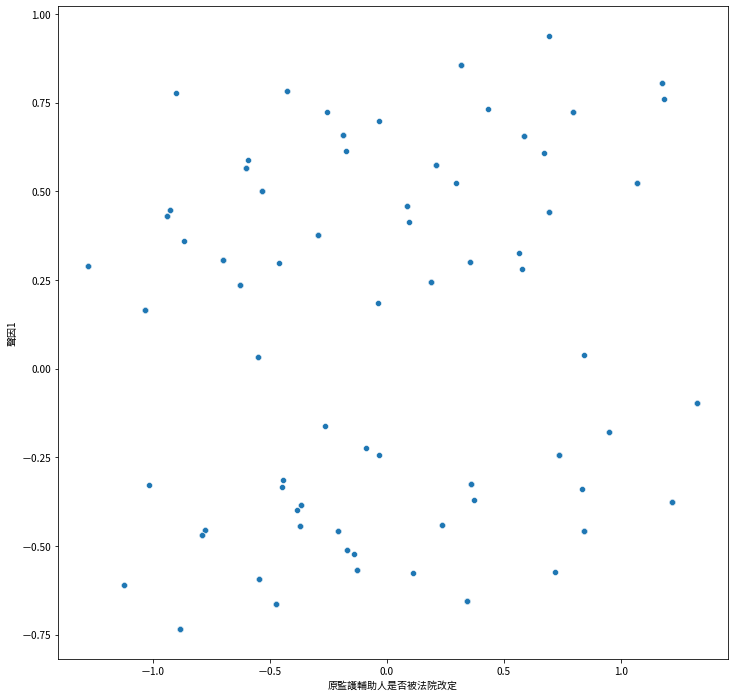

In [13]:
cc.pca2(cc.col(0), cc.col(9))

# 5. 複變數/多元迴歸

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import f_regression
from sklearn import preprocessing, linear_model


class MultipleRegression(Analysis):
  def load(self, columns_x, columns_y, binary_y=False):
    print('x', columns_x)
    print('y', columns_y)
    self.X = self.df[columns_x]
    self.y = self.df[columns_y]

    if binary_y:
      self.lm = linear_model.LogisticRegression() # 如果是二元y
    else:
      self.lm = LinearRegression() # 如果是數值y

    self.lm.fit(self.X, self.y)

    # 項目
    print('項目', self.X.columns)
    # 印出係數
    print('係數', self.lm.coef_)
    # 印出 p-value
    print('p-value', f_regression(self.X, self.y)[1])
    # 印出截距
    print('截距', self.lm.intercept_)

  def vars(self):
    # 模型績效
    mae = np.mean(abs(self.lm.predict(self.X) - self.y))
    mse = np.mean((self.lm.predict(self.X) - self.y) ** 2)
    r_squared = self.lm.score(self.X, self.y)
    adj_r_squared = r_squared - (1 - r_squared) * (self.X.shape[1] / (self.X.shape[0] - self.X.shape[1] - 1))

    # 印出模型績效
    print('mae:', mae, ' # 越小越好 單位就是y的單位')
    print('mse:', mse, '# 越小越好 單位就是y的單位')
    print('r2:', r_squared, '# 越大越好 模型適配程度 0.75以上好（可以畢業了） 0.5以上堪用（現實數據常常在這附近） 0.5以下（整個歪了')
    print('adj_r2:', adj_r_squared, '# 各係數標準化後的r2 越大越好 模型適配程度 0.75以上好（可以畢業了） 0.5以上堪用（現實數據常常在這')

  def predict(self, arr=[1, 1, 1, 1, 0, 0, 0, 0]):
    to_be_predicted = np.array([arr])
    predicted_sales = self.lm.predict(to_be_predicted)

    # 預測
    print('預測', predicted_sales)

In [15]:
m = MultipleRegression(gsheet_id, gsheet_name, auto_proc=True, to_drop=[
  'index',
  'UUID',
  '主管機關是否被法院改定 (1=是, 2=否)',
  '宣告性質',
  '原監護輔助人之類型'
])
m.replace_all_col_to_NaN('')
m.convert_to_numeric()
m.load(m.cols()[0:9], '原監護輔助人是否被法院改定')
m.vars()
m.predict([0, 0, 0, 0, 0, 0, 0, 0, 0])

x ['聲因1', '聲因2', '聲因3', '聲因4', '聲因5', '聲因6', '聲因7', '聲因8', '聲因9']
y 原監護輔助人是否被法院改定
項目 Index(['聲因1', '聲因2', '聲因3', '聲因4', '聲因5', '聲因6', '聲因7', '聲因8', '聲因9'], dtype='object')
係數 [ 0.21723589  0.19057472 -0.05920956  0.0978003  -0.1117113   0.02234406
  0.16219135  0.07738193  0.32062654]
p-value [2.88537687e-06 1.32157405e-04 3.90412389e-04 7.08345021e-01
 5.33720547e-06 7.29107469e-01 9.74240757e-05 6.61290079e-02
 3.84120694e-03]
截距 0.498071467551979
mae: 0.3667355802474947  # 越小越好 單位就是y的單位
mse: 0.17673367072213045 # 越小越好 單位就是y的單位
r2: 0.22890222568351593 # 越大越好 模型適配程度 0.75以上好（可以畢業了） 0.5以上堪用（現實數據常常在這附近） 0.5以下（整個歪了
adj_r2: 0.19385232685094847 # 各係數標準化後的r2 越大越好 模型適配程度 0.75以上好（可以畢業了） 0.5以上堪用（現實數據常常在這
預測 [0.49807147]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  "X does not have valid feature names, but"


# 6. 決策樹

In [20]:
import graphviz
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import f_regression
from sklearn import preprocessing, linear_model

class DecisionTree(Analysis):
  def load(self, columns_x, columns_y, binary_y):
    print('x', columns_x)
    print('y', columns_y)
    self.X = self.df[columns_x]
    self.y = self.df[columns_y]

    # 切分訓練與測試資料
    train_X, test_X, train_y, test_y = train_test_split(self.X, self.y, test_size = 0.2)

    if binary_y:
      lm = linear_model.LogisticRegression() # 如果是二元y
    else:
      lm = LinearRegression() # 如果是數值y

    # 建立分類器
    clf = tree.DecisionTreeClassifier(max_depth=2)
    self.my_clf = clf.fit(train_X, train_y)

    # 預測
    test_y_predicted = self.my_clf.predict(test_X)
    print('預測', test_y_predicted)

    # 標準答案
    print('標準答案', test_y.values)

    # 績效
    accuracy = metrics.accuracy_score(test_y, test_y_predicted)
    print('績效', accuracy)
  
  def sort(self):
    return np.sort(self.y.unique()).astype(str).tolist()

  def text_representation(self):
    text_representation = tree.export_text(self.my_clf)
    print(text_representation)
  
  def graph(self):
    # DOT data
    dot_data = tree.export_graphviz(self.my_clf, out_file=None, 
                    feature_names=self.X.columns.tolist(),  
                    class_names=self.sort(),
                    filled=True)

    # Draw graph
    return graphviz.Source(dot_data) 
  
  def tree(self):
    fig = plt.figure(figsize=(16,16))
    return tree.plot_tree(self.my_clf, 
              feature_names=self.X.columns.tolist(),  
              class_names=np.sort(self.y.unique()).astype(str).tolist(),
              filled=True)

In [21]:
d = DecisionTree(gsheet_id, gsheet_name, auto_proc=True, to_drop=[
  'index',
  'UUID',
  '主管機關是否被法院改定 (1=是, 2=否)',
  '宣告性質',
  '原監護輔助人之類型'
])
d.replace_all_col_to_NaN('')
d.convert_to_numeric()
d.load(d.cols()[0:8], '原監護輔助人是否被法院改定', binary_y=True)
d.text_representation()

x ['聲因1', '聲因2', '聲因3', '聲因4', '聲因5', '聲因6', '聲因7', '聲因8']
y 原監護輔助人是否被法院改定
預測 [1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 1 1 1 0 1]
標準答案 [1 1 0 1 1 1 1 0 1 1 1 1 1 1 0 0 1 0 0 1 0 0 1 1 0 1 1 0 1 0 1 0 1 1 0 1 1
 0 1 1 1 1]
績效 0.5952380952380952
|--- feature_2 <= 0.50
|   |--- feature_6 <= 0.50
|   |   |--- class: 1
|   |--- feature_6 >  0.50
|   |   |--- class: 1
|--- feature_2 >  0.50
|   |--- feature_5 <= 0.50
|   |   |--- class: 0
|   |--- feature_5 >  0.50
|   |   |--- class: 0



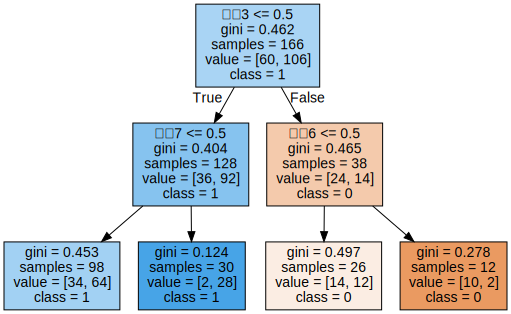

In [22]:
d.graph()

[Text(0.5, 0.8333333333333334, '聲因3 <= 0.5\ngini = 0.462\nsamples = 166\nvalue = [60, 106]\nclass = 1'),
 Text(0.25, 0.5, '聲因7 <= 0.5\ngini = 0.404\nsamples = 128\nvalue = [36, 92]\nclass = 1'),
 Text(0.125, 0.16666666666666666, 'gini = 0.453\nsamples = 98\nvalue = [34, 64]\nclass = 1'),
 Text(0.375, 0.16666666666666666, 'gini = 0.124\nsamples = 30\nvalue = [2, 28]\nclass = 1'),
 Text(0.75, 0.5, '聲因6 <= 0.5\ngini = 0.465\nsamples = 38\nvalue = [24, 14]\nclass = 0'),
 Text(0.625, 0.16666666666666666, 'gini = 0.497\nsamples = 26\nvalue = [14, 12]\nclass = 0'),
 Text(0.875, 0.16666666666666666, 'gini = 0.278\nsamples = 12\nvalue = [10, 2]\nclass = 0')]

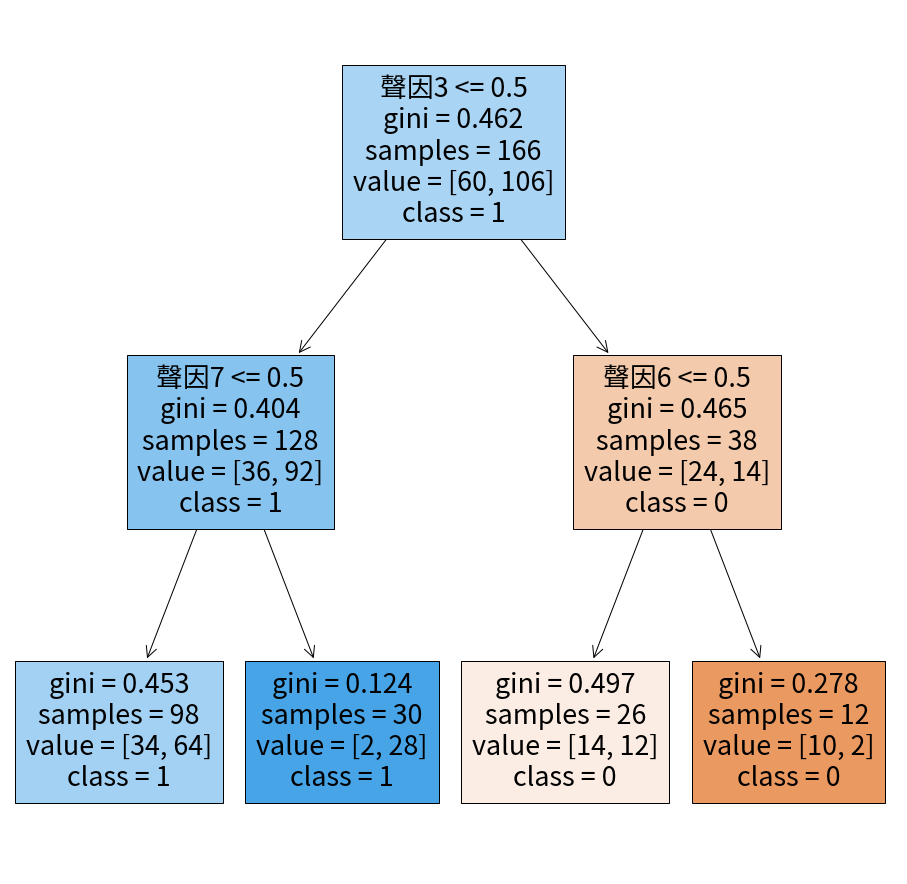

In [23]:
d.tree()

# 8. 需要分析內容 (監護宣告)


In [54]:
gsheet_name = gsheet_name2

## 8.1 馬賽克


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208 entries, 0 to 207
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   聲因1                       208 non-null    int64  
 1   聲因2                       208 non-null    int64  
 2   聲因3                       208 non-null    int64  
 3   聲因4                       208 non-null    int64  
 4   聲因5                       208 non-null    int64  
 5   聲因6                       208 non-null    int64  
 6   聲因7                       208 non-null    int64  
 7   聲因8                       208 non-null    int64  
 8   聲因9                       208 non-null    int64  
 9   原監護輔助人之人數（自然人）            208 non-null    int64  
 10  法院是否於聲請原因外考量「其他改定因素」      208 non-null    int64  
 11  法院是否認為原監護輔助人「年事已高」        45 non-null     float64
 12  法院是否考慮原監護輔助人之身體狀況         47 non-null     float64
 13  法院是否認為原監護輔助人「身體不堪負荷」      46 non-null     float64
 14  法院是否認為原監護輔

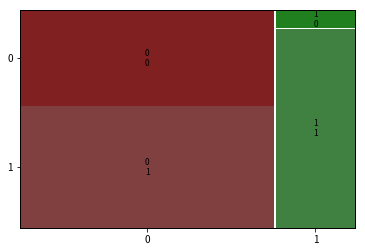




--------------------------------------------------
X 軸 = 聲因2
Y 軸 = 原監護輔助人是否被法院改定
--------------------------------------------------
原監護輔助人是否被法院改定   0   1
聲因2                  
0              69  95
1               5  39
p value is 0.00015796622528822568
兩者有關 Dependent (reject H0)


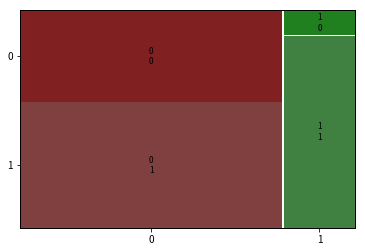




--------------------------------------------------
X 軸 = 聲因3
Y 軸 = 原監護輔助人是否被法院改定
--------------------------------------------------
原監護輔助人是否被法院改定   0    1
聲因3                   
0              48  115
1              26   19
p value is 0.0004413168818551797
兩者有關 Dependent (reject H0)


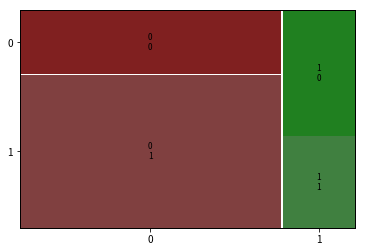




--------------------------------------------------
X 軸 = 聲因4
Y 軸 = 原監護輔助人是否被法院改定
--------------------------------------------------
原監護輔助人是否被法院改定   0    1
聲因4                   
0              69  123
1               5   11
p value is 0.7067060673575571
兩者無關 Independent (H0 holds true)


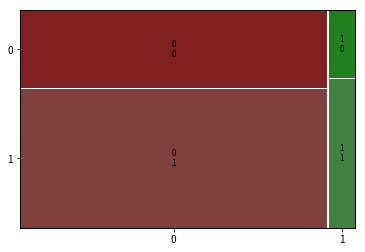




--------------------------------------------------
X 軸 = 聲因5
Y 軸 = 原監護輔助人是否被法院改定
--------------------------------------------------
原監護輔助人是否被法院改定   0    1
聲因5                   
0              37  107
1              37   27
p value is 7.982906934708254e-06
兩者有關 Dependent (reject H0)


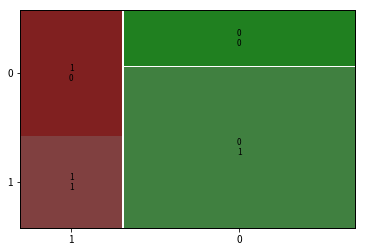




--------------------------------------------------
X 軸 = 聲因6
Y 軸 = 原監護輔助人是否被法院改定
--------------------------------------------------
原監護輔助人是否被法院改定   0    1
聲因6                   
0              57  106
1              17   28
p value is 0.7275684607117745
兩者無關 Independent (H0 holds true)


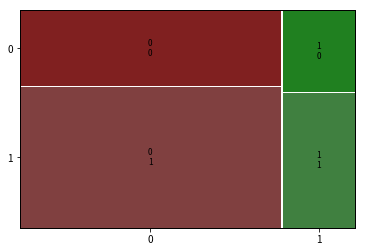




--------------------------------------------------
X 軸 = 聲因7
Y 軸 = 原監護輔助人是否被法院改定
--------------------------------------------------
原監護輔助人是否被法院改定   0    1
聲因7                   
0              71  100
1               3   34
p value is 0.00011850852222068599
兩者有關 Dependent (reject H0)


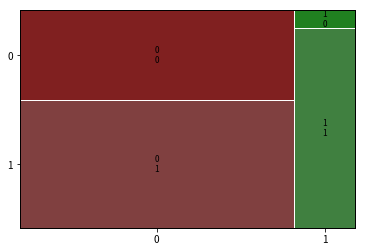




--------------------------------------------------
X 軸 = 聲因8
Y 軸 = 原監護輔助人是否被法院改定
--------------------------------------------------
原監護輔助人是否被法院改定   0   1
聲因8                  
0              43  60
1              31  74
p value is 0.06560428226878817
兩者無關 Independent (H0 holds true)


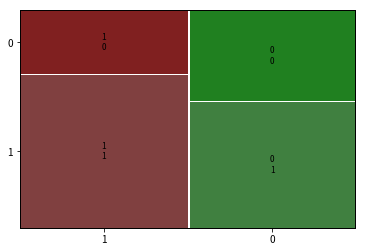




--------------------------------------------------
X 軸 = 聲因9
Y 軸 = 原監護輔助人是否被法院改定
--------------------------------------------------
原監護輔助人是否被法院改定   0    1
聲因9                   
0              74  120
1               0   14
p value is 0.003987990145961665
兩者有關 Dependent (reject H0)


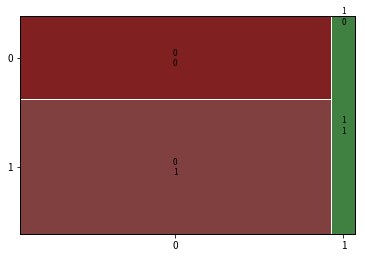




--------------------------------------------------
X 軸 = 原監護輔助人之人數（自然人）
Y 軸 = 原監護輔助人是否被法院改定
--------------------------------------------------
原監護輔助人是否被法院改定    0    1
原監護輔助人之人數（自然人）         
1               34  108
2               29   21
3                9    3
4                2    2
p value is 3.898743952263687e-06
兩者有關 Dependent (reject H0)


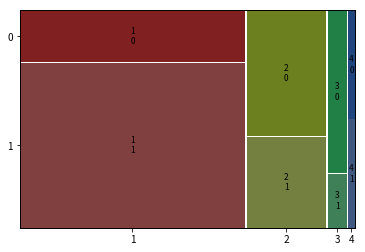




--------------------------------------------------
X 軸 = 法院是否於聲請原因外考量「其他改定因素」
Y 軸 = 原監護輔助人是否被法院改定
--------------------------------------------------
原監護輔助人是否被法院改定          0    1
法院是否於聲請原因外考量「其他改定因素」         
0                      9   22
1                     65  112
p value is 0.4093128868094039
兩者無關 Independent (H0 holds true)


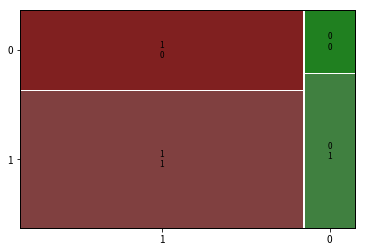




--------------------------------------------------
X 軸 = 法院是否認為原監護輔助人「年事已高」
Y 軸 = 原監護輔助人是否被法院改定
--------------------------------------------------
原監護輔助人是否被法院改定       0   1
法院是否認為原監護輔助人「年事已高」       
0.0                 2   0
1.0                 1  42
p value is 6.192133315488142e-08
兩者有關 Dependent (reject H0)


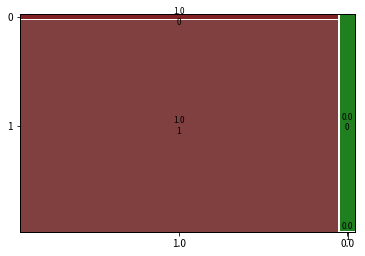




--------------------------------------------------
X 軸 = 法院是否考慮原監護輔助人之身體狀況
Y 軸 = 原監護輔助人是否被法院改定
--------------------------------------------------
原監護輔助人是否被法院改定      0   1
法院是否考慮原監護輔助人之身體狀況       
0.0                1   0
1.0                4  42
p value is 0.00339388795257212
兩者有關 Dependent (reject H0)


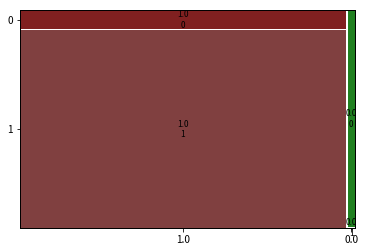




--------------------------------------------------
X 軸 = 法院是否認為原監護輔助人「身體不堪負荷」
Y 軸 = 原監護輔助人是否被法院改定
--------------------------------------------------
原監護輔助人是否被法院改定         0   1
法院是否認為原監護輔助人「身體不堪負荷」       
0.0                   3   0
1.0                   2  41
p value is 2.8983534585172854e-07
兩者有關 Dependent (reject H0)


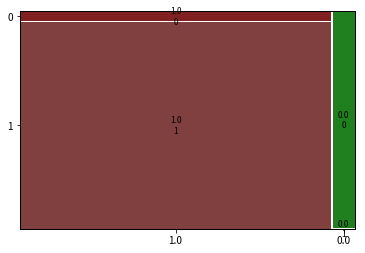




--------------------------------------------------
X 軸 = 法院是否認為原監護輔助人「盜領存款」
Y 軸 = 原監護輔助人是否被法院改定
--------------------------------------------------
原監護輔助人是否被法院改定        0   1
法院是否認為原監護輔助人「盜領存款」        
0.0                 16   0
1.0                  1  10
p value is 1.5366243673480033e-06
兩者有關 Dependent (reject H0)


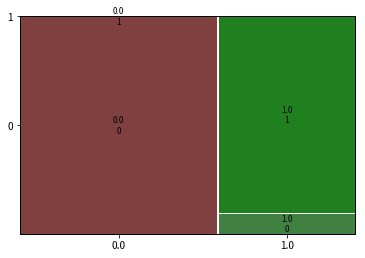




--------------------------------------------------
X 軸 = 法院是否認為原監護輔助人「不當處理本人之不動產」
Y 軸 = 原監護輔助人是否被法院改定
--------------------------------------------------
原監護輔助人是否被法院改定              0   1
法院是否認為原監護輔助人「不當處理本人之不動產」        
0.0                       15   1
1.0                        1  11
p value is 6.189072379328499e-06
兩者有關 Dependent (reject H0)


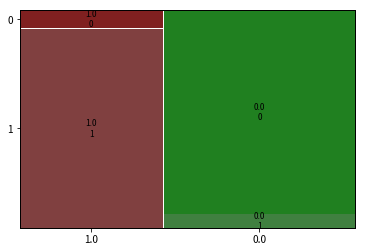




--------------------------------------------------
X 軸 = 法院是否認為原監護輔助人「與本人有利害關係」
Y 軸 = 原監護輔助人是否被法院改定
--------------------------------------------------
原監護輔助人是否被法院改定           0   1
法院是否認為原監護輔助人「與本人有利害關係」       
0.0                     6   1
1.0                     1  14
p value is 0.00020918161372714906
兩者有關 Dependent (reject H0)


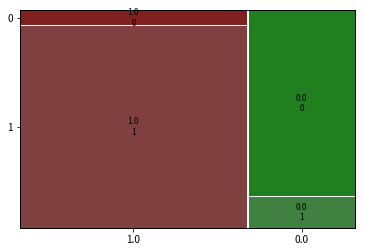




--------------------------------------------------
X 軸 = 法院是否認為原監護輔助人有「其他不當行為」
Y 軸 = 原監護輔助人是否被法院改定
--------------------------------------------------
原監護輔助人是否被法院改定           0   1
法院是否認為原監護輔助人有「其他不當行為」        
0.0                    35   2
1.0                     4  24
p value is 5.966661863478195e-11
兩者有關 Dependent (reject H0)


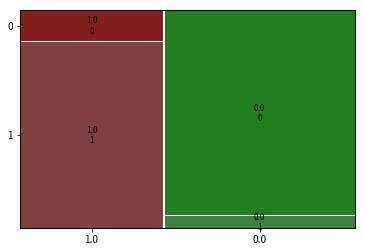




--------------------------------------------------
X 軸 = 法院是否認為原監護輔助人是「本人之實際照顧者」
Y 軸 = 原監護輔助人是否被法院改定
--------------------------------------------------
原監護輔助人是否被法院改定             0   1
法院是否認為原監護輔助人是「本人之實際照顧者」        
0.0                      39  55
1.0                      20   6
p value is 0.0013807173394412438
兩者有關 Dependent (reject H0)


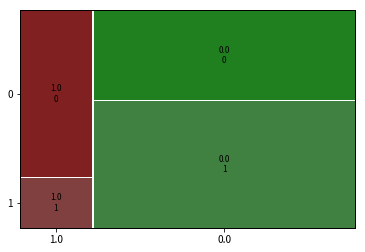




--------------------------------------------------
X 軸 = 法院是否認為監護人現為本人廣義照顧者
Y 軸 = 原監護輔助人是否被法院改定
--------------------------------------------------
原監護輔助人是否被法院改定        0    1
法院是否認為監護人現為本人廣義照顧者         
0                   24  121
1                   50   13
p value is 3.468242725985351e-18
兩者有關 Dependent (reject H0)


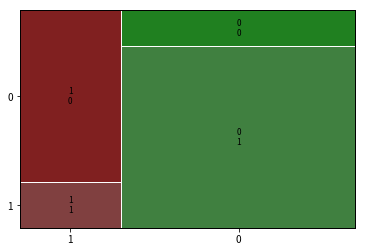




--------------------------------------------------
X 軸 = 原監護輔助人是否有意願續任
Y 軸 = 原監護輔助人是否被法院改定
--------------------------------------------------
原監護輔助人是否被法院改定   0   1
原監護輔助人是否有意願續任        
0.0             1  62
1.0            67  13
p value is 1.555983678342909e-22
兩者有關 Dependent (reject H0)


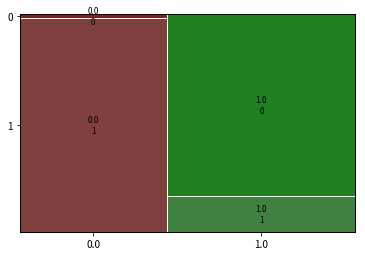




--------------------------------------------------
X 軸 = 專業人士訪視報告之「改定建議」
Y 軸 = 原監護輔助人是否被法院改定
--------------------------------------------------
原監護輔助人是否被法院改定     0   1
專業人士訪視報告之「改定建議」        
0.0              41  16
1.0               3  26
p value is 6.610788103146333e-08
兩者有關 Dependent (reject H0)


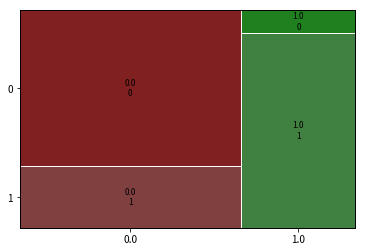




--------------------------------------------------
X 軸 = 本人之「改定建議」
Y 軸 = 原監護輔助人是否被法院改定
--------------------------------------------------
原監護輔助人是否被法院改定  0  1
本人之「改定建議」          
0.0            5  0
1.0            0  1
p value is 0.014305878435429641
兩者有關 Dependent (reject H0)


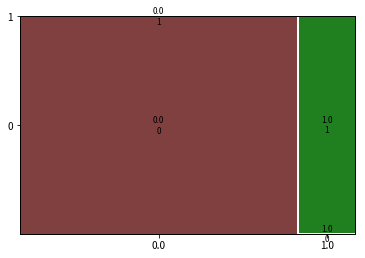




--------------------------------------------------
X 軸 = 其他親屬、關係人之「改定建議」
Y 軸 = 原監護輔助人是否被法院改定
--------------------------------------------------
原監護輔助人是否被法院改定     0   1
其他親屬、關係人之「改定建議」        
0.0              19   7
1.0               3  71
p value is 2.698485705539998e-13
兩者有關 Dependent (reject H0)


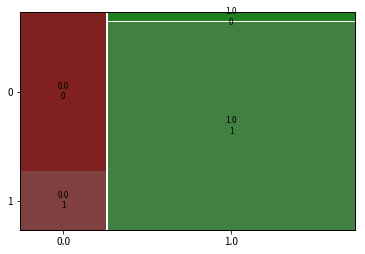

In [ ]:
k = Corr(gsheet_id, gsheet_name, to_drop=[
  'index',
  'UUID',
  '主管機關是否被法院改定 (1=是, 2=否)',
  '宣告性質',
  '原監護輔助人之類型'
])
k.replace_all_col_to_NaN('')
k.convert_to_numeric()
k.info()

for i in range(0, 24):
  if i == 24:
    break
  print(f"\n\n")
  k.chi2_contingency_and_mosaic(k.cols()[i], '原監護輔助人是否被法院改定')

## 8.2.1 PCA 聲因1-9

                    PC0       PC1       PC2       PC3       PC4       PC5  \
聲因1            0.408931 -0.352140 -0.103773  0.112488  0.196233  0.192992   
聲因2            0.350827 -0.472736 -0.036012  0.126900 -0.066500  0.094980   
聲因3           -0.416854 -0.024046 -0.109862  0.057779  0.464636  0.502103   
聲因4           -0.026615  0.263837  0.446286  0.671907  0.310606 -0.215645   
聲因5           -0.466965 -0.061504 -0.249676 -0.020805  0.160326  0.220285   
聲因6           -0.125897  0.092258 -0.442093  0.649863 -0.523982  0.107699   
聲因7            0.310775  0.458189 -0.016590 -0.015884  0.305786  0.068734   
聲因8            0.110039  0.125249 -0.702919 -0.017420  0.359843 -0.521345   
聲因9            0.164346  0.579242 -0.068354 -0.249650 -0.304089  0.300780   
原監護輔助人是否被法院改定  0.406957  0.094288 -0.140946  0.175525  0.170248  0.477499   

                    PC6       PC7       PC8       PC9  
聲因1            0.385772  0.151692 -0.270126  0.603985  
聲因2           -0.157105  0.444098  0.547

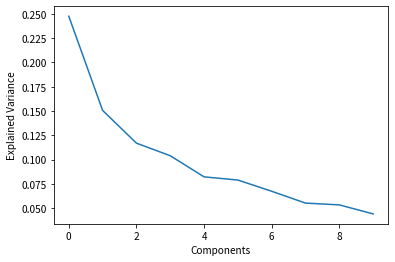

In [ ]:
p = Corr(gsheet_id, gsheet_name, to_drop=[
  'index',
  'UUID',
  #'聲因1',
  #'聲因2',
  #'聲因3',
  #'聲因4',
  #'聲因5',
  #'聲因6',
  #'聲因7',
  #'聲因8',
  #'聲因9',
  '宣告性質',
  '原監護輔助人之類型',
  '原監護輔助人之人數（自然人）',
  '主管機關是否被法院改定 (1=是, 2=否)',
  '法院是否於聲請原因外考量「其他改定因素」',
  '法院是否認為原監護輔助人「年事已高」',
  '法院是否考慮原監護輔助人之身體狀況',
  '法院是否認為原監護輔助人「身體不堪負荷」',
  '法院是否認為原監護輔助人「盜領存款」',
  '法院是否認為原監護輔助人「不當處理本人之不動產」',
  '原監護輔助人是否與本人有「利害關係」',
  '法院是否認為原監護輔助人有「其他不當行為」',
  '法院是否認為原監護輔助人是「本人之實際照顧者」',
  '監護輔助人是否為本人「廣義照顧者」',
  '原監護輔助人是否有意願續任',
  '專業人士訪視報告之「改定建議」',
  '本人之「改定建議」',
  '其他親屬、關係人之「改定建議」',
  #'原監護輔助人是否被法院改定'
])
p.convert_to_numeric()
p.pca()

0 聲因1
9 原監護輔助人是否被法院改定
   原監護輔助人是否被法院改定       聲因1
0        0.20917  0.575047
1       -0.29226  0.377142
2        0.18973  0.244237
3        0.20917  0.575047
4       -0.29226  0.377142


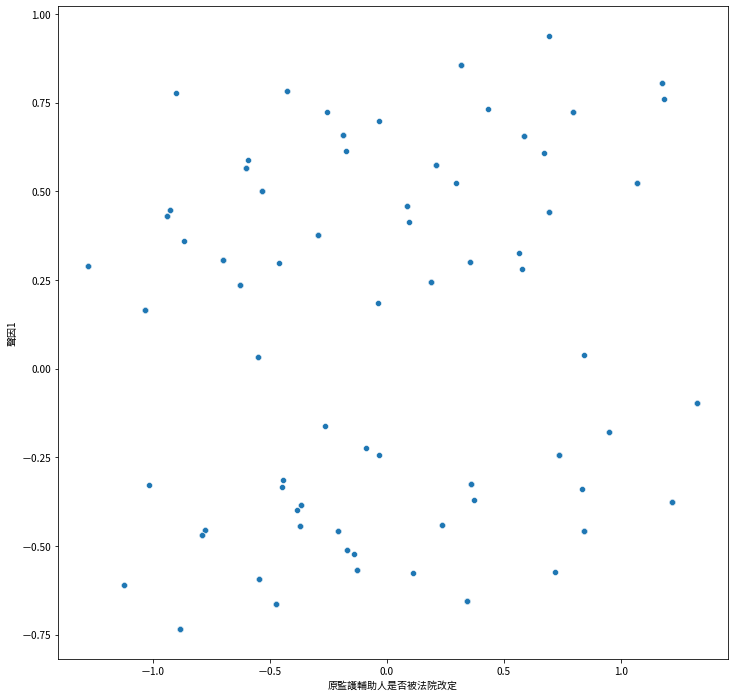

In [ ]:
p.pca2(p.col(0), p.col(9))

## 8.2.2 PCA Filter 聲因

----------------------------------------------------------------------------------------------------
Filter 聲因1 208
Dropping ['聲因1', '聲因2', '聲因3', '聲因4', '聲因5', '聲因6', '聲因7', '聲因8', '聲因9']
----------------------------------------------------------------------------------------------------
                               PC0       PC1       PC2       PC3       PC4  \
法院是否於聲請原因外考量「其他改定因素」     -0.067355  0.210936  0.136595  0.090527 -0.091350   
法院是否認為原監護輔助人「年事已高」        0.326400  0.189322  0.167579  0.137624  0.073640   
法院是否考慮原監護輔助人之身體狀況         0.370353  0.401371  0.257287 -0.033133  0.185567   
法院是否認為原監護輔助人「身體不堪負荷」      0.369253  0.392613  0.259224 -0.032557  0.193496   
法院是否認為原監護輔助人「盜領存款」       -0.222521 -0.038626  0.398884 -0.095040  0.234821   
法院是否認為原監護輔助人「不當處理本人之不動產」 -0.170840 -0.197717  0.568562  0.127548  0.010993   
法院是否認為原監護輔助人「與本人有利害關係」   -0.070446 -0.233462 -0.051609 -0.329834  0.645221   
法院是否認為原監護輔助人有「其他不當行為」    -0.320266 -0.090747  0.419733 -0.114202 -0.017106   
法院是否認為原監

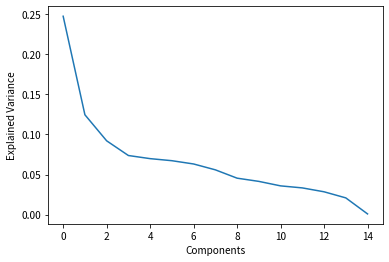

1 法院是否認為原監護輔助人「年事已高」
   原監護輔助人是否被法院改定  法院是否認為原監護輔助人「年事已高」
0    -562.240760          602.719596
1     -71.123305         -212.916565
2    -562.103024          602.371358
3    -552.566292           95.843581
4     248.388125         -746.822520


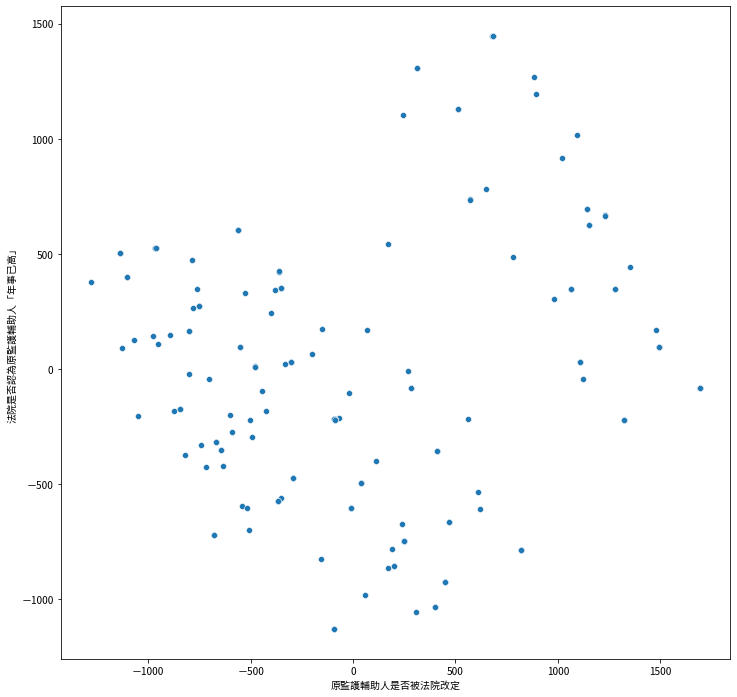

In [ ]:
for i in range(1, 10):
  p = Corr(gsheet_id, gsheet_name, to_drop=[
    'index',
    'UUID',
    '宣告性質',
    '原監護輔助人之類型',
    '原監護輔助人之人數（自然人）',
    '主管機關是否被法院改定 (1=是, 2=否)',
  ])
  for col in p.df.columns:
    p.replace_col_to(col, '', -1000) # 替換 '' to -100 因為決策樹不支援 NaN
  p.convert_to_numeric()
  print('-'*100)
  print(f"Filter 聲因{str(i)} {len(p.df)}")
  print(f"Dropping {p.cols()[0:9]}")
  print('-'*100)
  p.drop(p.cols()[0:9])
  p.pca()
  p.pca2(p.col(1), '原監護輔助人是否被法院改定')
  break

## 8.3.1 決策樹1

x ['聲因1', '聲因2', '聲因3', '聲因4', '聲因5', '聲因6', '聲因7', '聲因8', '聲因9']
y 原監護輔助人是否被法院改定
預測 [0 1 1 0 0 1 1 1 0 1 1 0 0 0 1 1 1 1 1 1 0 0 0 1 0 1 1 1 0 1 1 1 1 1 1 1 1
 1 0 1 0 1]
標準答案 [0 1 0 0 0 1 1 1 0 1 0 0 0 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 0 0 1 0 0 1 0
 0 1 1 1 1]
績效 0.5952380952380952
|--- feature_4 <= 0.50
|   |--- feature_1 <= 0.50
|   |   |--- class: 1
|   |--- feature_1 >  0.50
|   |   |--- class: 1
|--- feature_4 >  0.50
|   |--- feature_6 <= 0.50
|   |   |--- class: 0
|   |--- feature_6 >  0.50
|   |   |--- class: 1



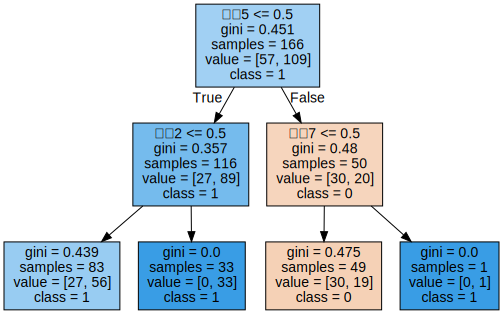

In [33]:
dt = DecisionTree(gsheet_id, gsheet_name, auto_proc=True, to_drop=[
  'index',
  'UUID',
  '主管機關是否被法院改定 (1=是, 2=否)',
  '宣告性質',
  '原監護輔助人之類型'
])
dt.convert_to_numeric()
dt.load(dt.cols()[0:9], '原監護輔助人是否被法院改定', binary_y=True)
dt.text_representation()
dt.graph()

208
x ['法院是否認為原監護輔助人「身體不堪負荷」', '法院是否認為原監護輔助人「盜領存款」', '法院是否認為原監護輔助人「不當處理本人之不動產」', '法院是否認為原監護輔助人「與本人有利害關係」', '法院是否認為原監護輔助人有「其他不當行為」', '法院是否認為原監護輔助人是「本人之實際照顧者」', '法院是否認為監護人現為本人廣義照顧者', '原監護輔助人是否有意願續任', '專業人士訪視報告之「改定建議」', '本人之「改定建議」', '其他親屬、關係人之「改定建議」']
y 原監護輔助人是否被法院改定
預測 [0 1 0 0 1 1 0 1 1 1 1 1 0 1 0 1 0 1 0 0 1 1 0 0 0 1 1 0 0 0 1 1 1 1 1 1 1
 0 0 1 1 1]
標準答案 [0 1 0 0 1 1 0 0 1 1 1 1 0 1 0 1 0 1 0 0 1 1 0 0 1 1 1 0 0 0 1 1 1 1 0 1 0
 0 0 1 1 1]
績效 0.9047619047619048
|--- feature_7 <= 0.50
|   |--- feature_6 <= 0.50
|   |   |--- class: 1
|   |--- feature_6 >  0.50
|   |   |--- class: 1
|--- feature_7 >  0.50
|   |--- feature_1 <= 0.50
|   |   |--- class: 0
|   |--- feature_1 >  0.50
|   |   |--- class: 1



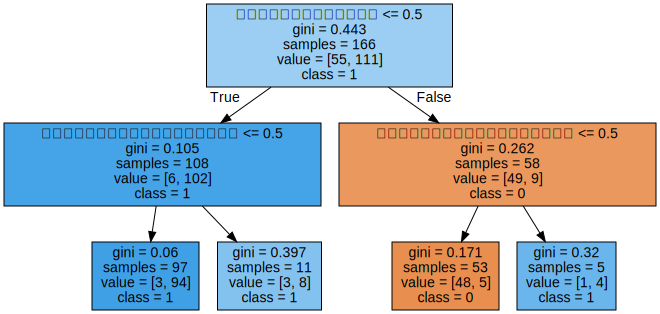

In [34]:
dt2 = DecisionTree(gsheet_id, gsheet_name, auto_proc=True, to_drop=[
  'index',
  'UUID',
  '主管機關是否被法院改定 (1=是, 2=否)',
  '宣告性質',
  '原監護輔助人之類型'
])
print(len(dt2.df))
for col in dt2.df.columns:
  dt2.replace_col_to(col, '', 0) # 替換 '' to -100 因為決策樹不支援 NaN
dt2.convert_to_numeric()
dt2.load(dt2.cols()[13:24], '原監護輔助人是否被法院改定', binary_y=True)
dt2.text_representation()
dt2.graph()

## 8.3.2 決策樹 Filter 聲因 1-9

----------------------------------------------------------------------------------------------------
Filter 聲因1 == 1 len = 49
----------------------------------------------------------------------------------------------------
x ['法院是否認為原監護輔助人「身體不堪負荷」', '法院是否認為原監護輔助人「盜領存款」', '法院是否認為原監護輔助人「不當處理本人之不動產」', '法院是否認為原監護輔助人「與本人有利害關係」', '法院是否認為原監護輔助人有「其他不當行為」', '法院是否認為原監護輔助人是「本人之實際照顧者」', '法院是否認為監護人現為本人廣義照顧者', '原監護輔助人是否有意願續任', '專業人士訪視報告之「改定建議」', '本人之「改定建議」', '其他親屬、關係人之「改定建議」']
y 原監護輔助人是否被法院改定
預測 [1 1 1 0 1 1 1 0 1 1]
標準答案 [1 1 1 0 1 1 1 0 1 1]
績效 1.0
|--- feature_7 <= 0.50
|   |--- class: 1
|--- feature_7 >  0.50
|   |--- class: 0



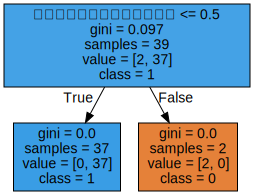

----------------------------------------------------------------------------------------------------
Filter 聲因2 == 1 len = 44
----------------------------------------------------------------------------------------------------
x ['法院是否認為原監護輔助人「身體不堪負荷」', '法院是否認為原監護輔助人「盜領存款」', '法院是否認為原監護輔助人「不當處理本人之不動產」', '法院是否認為原監護輔助人「與本人有利害關係」', '法院是否認為原監護輔助人有「其他不當行為」', '法院是否認為原監護輔助人是「本人之實際照顧者」', '法院是否認為監護人現為本人廣義照顧者', '原監護輔助人是否有意願續任', '專業人士訪視報告之「改定建議」', '本人之「改定建議」', '其他親屬、關係人之「改定建議」']
y 原監護輔助人是否被法院改定
預測 [1 1 1 1 0 1 1 1 1]
標準答案 [1 1 1 1 0 1 1 1 1]
績效 1.0
|--- feature_7 <= 0.50
|   |--- class: 1
|--- feature_7 >  0.50
|   |--- class: 0



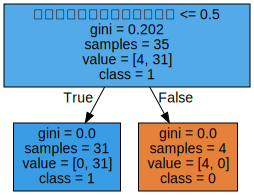

----------------------------------------------------------------------------------------------------
Filter 聲因3 == 1 len = 45
----------------------------------------------------------------------------------------------------
x ['法院是否認為原監護輔助人「身體不堪負荷」', '法院是否認為原監護輔助人「盜領存款」', '法院是否認為原監護輔助人「不當處理本人之不動產」', '法院是否認為原監護輔助人「與本人有利害關係」', '法院是否認為原監護輔助人有「其他不當行為」', '法院是否認為原監護輔助人是「本人之實際照顧者」', '法院是否認為監護人現為本人廣義照顧者', '原監護輔助人是否有意願續任', '專業人士訪視報告之「改定建議」', '本人之「改定建議」', '其他親屬、關係人之「改定建議」']
y 原監護輔助人是否被法院改定
預測 [1 0 0 0 0 0 1 0 1]
標準答案 [0 0 1 1 0 0 1 0 1]
績效 0.6666666666666666
|--- feature_1 <= 0.50
|   |--- feature_4 <= 0.50
|   |   |--- class: 0
|   |--- feature_4 >  0.50
|   |   |--- class: 1
|--- feature_1 >  0.50
|   |--- class: 1



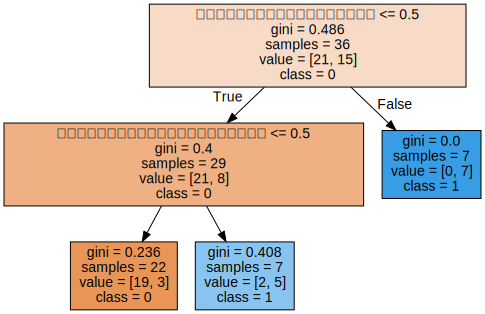

----------------------------------------------------------------------------------------------------
Filter 聲因4 == 1 len = 16
----------------------------------------------------------------------------------------------------
x ['法院是否認為原監護輔助人「身體不堪負荷」', '法院是否認為原監護輔助人「盜領存款」', '法院是否認為原監護輔助人「不當處理本人之不動產」', '法院是否認為原監護輔助人「與本人有利害關係」', '法院是否認為原監護輔助人有「其他不當行為」', '法院是否認為原監護輔助人是「本人之實際照顧者」', '法院是否認為監護人現為本人廣義照顧者', '原監護輔助人是否有意願續任', '專業人士訪視報告之「改定建議」', '本人之「改定建議」', '其他親屬、關係人之「改定建議」']
y 原監護輔助人是否被法院改定
預測 [1 1 0 1]
標準答案 [1 1 0 1]
績效 1.0
|--- feature_3 <= 0.50
|   |--- class: 0
|--- feature_3 >  0.50
|   |--- feature_5 <= 0.50
|   |   |--- class: 1
|   |--- feature_5 >  0.50
|   |   |--- class: 0



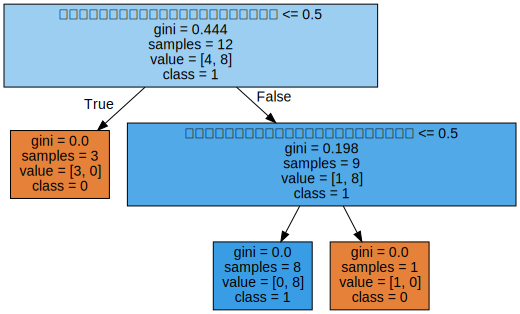

----------------------------------------------------------------------------------------------------
Filter 聲因5 == 1 len = 64
----------------------------------------------------------------------------------------------------
x ['法院是否認為原監護輔助人「身體不堪負荷」', '法院是否認為原監護輔助人「盜領存款」', '法院是否認為原監護輔助人「不當處理本人之不動產」', '法院是否認為原監護輔助人「與本人有利害關係」', '法院是否認為原監護輔助人有「其他不當行為」', '法院是否認為原監護輔助人是「本人之實際照顧者」', '法院是否認為監護人現為本人廣義照顧者', '原監護輔助人是否有意願續任', '專業人士訪視報告之「改定建議」', '本人之「改定建議」', '其他親屬、關係人之「改定建議」']
y 原監護輔助人是否被法院改定
預測 [0 0 0 1 1 0 0 1 0 1 0 1 1]
標準答案 [0 0 0 1 1 0 0 1 0 1 0 1 1]
績效 1.0
|--- feature_4 <= 0.50
|   |--- feature_1 <= 0.50
|   |   |--- class: 0
|   |--- feature_1 >  0.50
|   |   |--- class: 1
|--- feature_4 >  0.50
|   |--- feature_7 <= 0.50
|   |   |--- class: 1
|   |--- feature_7 >  0.50
|   |   |--- class: 1



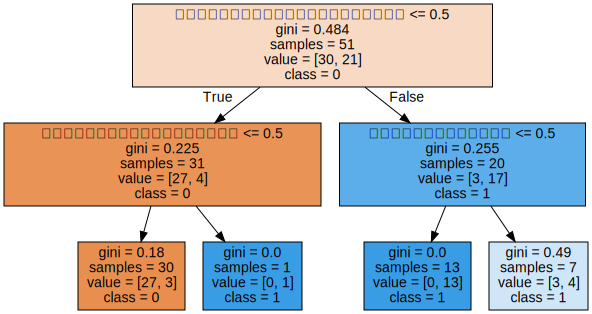

----------------------------------------------------------------------------------------------------
Filter 聲因6 == 1 len = 45
----------------------------------------------------------------------------------------------------
x ['法院是否認為原監護輔助人「身體不堪負荷」', '法院是否認為原監護輔助人「盜領存款」', '法院是否認為原監護輔助人「不當處理本人之不動產」', '法院是否認為原監護輔助人「與本人有利害關係」', '法院是否認為原監護輔助人有「其他不當行為」', '法院是否認為原監護輔助人是「本人之實際照顧者」', '法院是否認為監護人現為本人廣義照顧者', '原監護輔助人是否有意願續任', '專業人士訪視報告之「改定建議」', '本人之「改定建議」', '其他親屬、關係人之「改定建議」']
y 原監護輔助人是否被法院改定
預測 [0 1 1 1 1 0 1 1 0]
標準答案 [0 1 1 1 1 0 1 1 0]
績效 1.0
|--- feature_7 <= 0.50
|   |--- feature_6 <= 0.50
|   |   |--- class: 1
|   |--- feature_6 >  0.50
|   |   |--- class: 0
|--- feature_7 >  0.50
|   |--- feature_3 <= 0.50
|   |   |--- class: 0
|   |--- feature_3 >  0.50
|   |   |--- class: 1



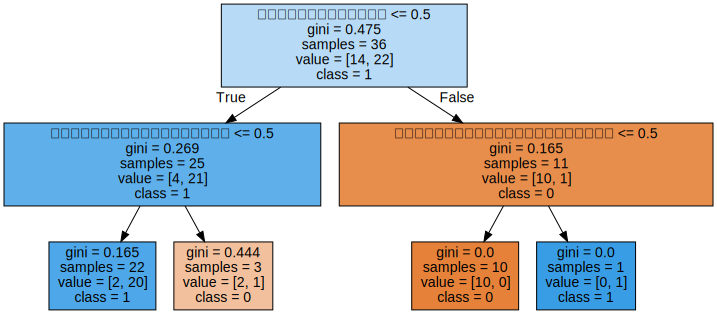

----------------------------------------------------------------------------------------------------
Filter 聲因7 == 1 len = 37
----------------------------------------------------------------------------------------------------
x ['法院是否認為原監護輔助人「身體不堪負荷」', '法院是否認為原監護輔助人「盜領存款」', '法院是否認為原監護輔助人「不當處理本人之不動產」', '法院是否認為原監護輔助人「與本人有利害關係」', '法院是否認為原監護輔助人有「其他不當行為」', '法院是否認為原監護輔助人是「本人之實際照顧者」', '法院是否認為監護人現為本人廣義照顧者', '原監護輔助人是否有意願續任', '專業人士訪視報告之「改定建議」', '本人之「改定建議」', '其他親屬、關係人之「改定建議」']
y 原監護輔助人是否被法院改定
預測 [1 1 1 1 1 1 1 1]
標準答案 [1 1 1 1 1 1 1 1]
績效 1.0
|--- feature_7 <= 0.50
|   |--- feature_10 <= 0.50
|   |   |--- class: 1
|   |--- feature_10 >  0.50
|   |   |--- class: 1
|--- feature_7 >  0.50
|   |--- class: 0



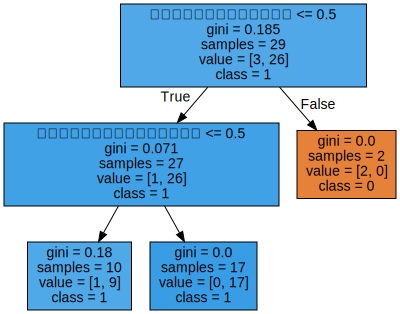

----------------------------------------------------------------------------------------------------
Filter 聲因8 == 1 len = 105
----------------------------------------------------------------------------------------------------
x ['法院是否認為原監護輔助人「身體不堪負荷」', '法院是否認為原監護輔助人「盜領存款」', '法院是否認為原監護輔助人「不當處理本人之不動產」', '法院是否認為原監護輔助人「與本人有利害關係」', '法院是否認為原監護輔助人有「其他不當行為」', '法院是否認為原監護輔助人是「本人之實際照顧者」', '法院是否認為監護人現為本人廣義照顧者', '原監護輔助人是否有意願續任', '專業人士訪視報告之「改定建議」', '本人之「改定建議」', '其他親屬、關係人之「改定建議」']
y 原監護輔助人是否被法院改定
預測 [1 0 1 1 1 1 1 1 0 1 1 0 0 1 1 0 1 1 1 1 1]
標準答案 [1 0 1 1 1 1 1 1 0 1 1 0 0 1 1 0 1 1 1 1 1]
績效 1.0
|--- feature_7 <= 0.50
|   |--- feature_0 <= 0.50
|   |   |--- class: 1
|   |--- feature_0 >  0.50
|   |   |--- class: 1
|--- feature_7 >  0.50
|   |--- feature_1 <= 0.50
|   |   |--- class: 0
|   |--- feature_1 >  0.50
|   |   |--- class: 1



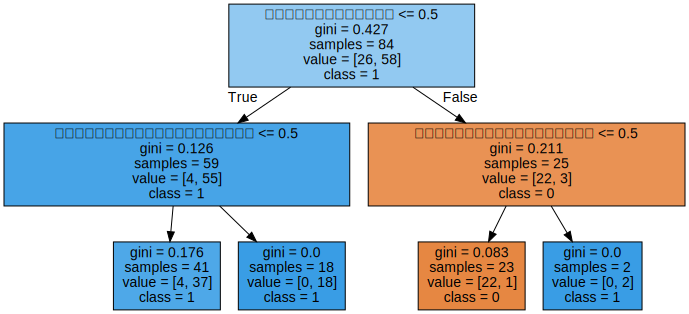

----------------------------------------------------------------------------------------------------
Filter 聲因9 == 1 len = 14
----------------------------------------------------------------------------------------------------
x ['法院是否認為原監護輔助人「身體不堪負荷」', '法院是否認為原監護輔助人「盜領存款」', '法院是否認為原監護輔助人「不當處理本人之不動產」', '法院是否認為原監護輔助人「與本人有利害關係」', '法院是否認為原監護輔助人有「其他不當行為」', '法院是否認為原監護輔助人是「本人之實際照顧者」', '法院是否認為監護人現為本人廣義照顧者', '原監護輔助人是否有意願續任', '專業人士訪視報告之「改定建議」', '本人之「改定建議」', '其他親屬、關係人之「改定建議」']
y 原監護輔助人是否被法院改定
預測 [1 1 1]
標準答案 [1 1 1]
績效 1.0
|--- class: 0



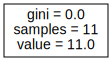

In [55]:
from IPython.display import display

def filter_tree(query):
  p = DecisionTree(gsheet_id, gsheet_name, auto_proc=True, to_drop=[
    'index',
    'UUID',
    '主管機關是否被法院改定 (1=是, 2=否)',
    '宣告性質',
    '原監護輔助人之類型'
  ])
  for col in p.df.columns:
    p.replace_col_to(col, '', 0) # 替換 '' to 0 因為決策樹不支援 NaN
  p.convert_to_numeric()
  p.df = p.df.query(query)
  p.df = p.df.reset_index(drop=True)
  print('-'*100)
  print(f"Filter {query} len = {len(p.df)}")
  print('-'*100)
  p.load(p.cols()[13:24], p.cols()[24], binary_y=True)
  p.text_representation()
  display(p.graph())

for i in range(1, 10):
  filter_tree(f"聲因{str(i)} == 1")


## 8.3.3 決策樹 Filter 聲因 3,4

----------------------------------------------------------------------------------------------------
Filter 聲因3 == 1 | 聲因4 == 1 len = 57
----------------------------------------------------------------------------------------------------
x ['法院是否認為原監護輔助人「身體不堪負荷」', '法院是否認為原監護輔助人「盜領存款」', '法院是否認為原監護輔助人「不當處理本人之不動產」', '法院是否認為原監護輔助人「與本人有利害關係」', '法院是否認為原監護輔助人有「其他不當行為」', '法院是否認為原監護輔助人是「本人之實際照顧者」', '法院是否認為監護人現為本人廣義照顧者', '原監護輔助人是否有意願續任', '專業人士訪視報告之「改定建議」', '本人之「改定建議」', '其他親屬、關係人之「改定建議」']
y 原監護輔助人是否被法院改定
預測 [0 1 0 0 0 1 0 0 1 0 0 1]
標準答案 [1 1 1 1 0 1 0 0 0 0 0 0]
績效 0.5833333333333334
|--- feature_6 <= 0.50
|   |--- feature_3 <= 0.50
|   |   |--- class: 1
|   |--- feature_3 >  0.50
|   |   |--- class: 1
|--- feature_6 >  0.50
|   |--- feature_8 <= 0.50
|   |   |--- class: 0
|   |--- feature_8 >  0.50
|   |   |--- class: 1



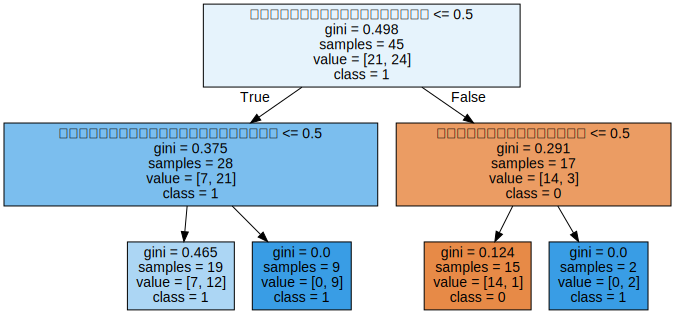

In [36]:
filter_tree("聲因3 == 1 | 聲因4 == 1")

## 8.3.4 決策樹 Filter 聲因 5,6

----------------------------------------------------------------------------------------------------
Filter 聲因5 == 1 | 聲因6 == 1 len = 89
----------------------------------------------------------------------------------------------------
x ['法院是否認為原監護輔助人「身體不堪負荷」', '法院是否認為原監護輔助人「盜領存款」', '法院是否認為原監護輔助人「不當處理本人之不動產」', '法院是否認為原監護輔助人「與本人有利害關係」', '法院是否認為原監護輔助人有「其他不當行為」', '法院是否認為原監護輔助人是「本人之實際照顧者」', '法院是否認為監護人現為本人廣義照顧者', '原監護輔助人是否有意願續任', '專業人士訪視報告之「改定建議」', '本人之「改定建議」', '其他親屬、關係人之「改定建議」']
y 原監護輔助人是否被法院改定
預測 [1 0 1 0 1 1 0 0 0 0 0 0 1 1 0 1 0 0]
標準答案 [1 0 1 1 1 0 0 0 0 0 0 1 0 1 0 1 1 1]
績效 0.6666666666666666
|--- feature_7 <= 0.50
|   |--- feature_4 <= 0.50
|   |   |--- class: 1
|   |--- feature_4 >  0.50
|   |   |--- class: 1
|--- feature_7 >  0.50
|   |--- feature_1 <= 0.50
|   |   |--- class: 0
|   |--- feature_1 >  0.50
|   |   |--- class: 1



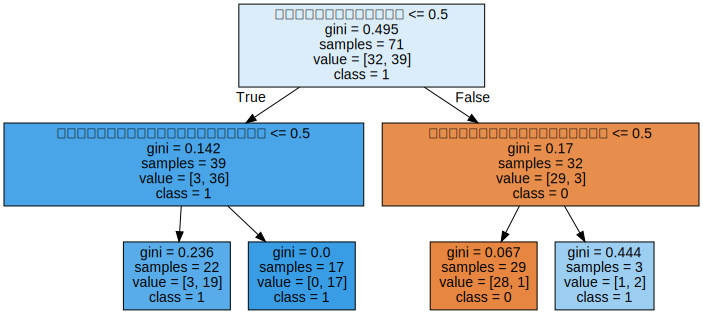

In [37]:
filter_tree("聲因5 == 1 | 聲因6 == 1")

## 8.3.5 決策樹 Filter 聲因 1,2,9

----------------------------------------------------------------------------------------------------
Filter 聲因1 == 1 | 聲因2 == 1 len = 66
----------------------------------------------------------------------------------------------------
x ['法院是否認為原監護輔助人「身體不堪負荷」', '法院是否認為原監護輔助人「盜領存款」', '法院是否認為原監護輔助人「不當處理本人之不動產」', '法院是否認為原監護輔助人「與本人有利害關係」', '法院是否認為原監護輔助人有「其他不當行為」', '法院是否認為原監護輔助人是「本人之實際照顧者」', '法院是否認為監護人現為本人廣義照顧者', '原監護輔助人是否有意願續任', '專業人士訪視報告之「改定建議」', '本人之「改定建議」', '其他親屬、關係人之「改定建議」']
y 原監護輔助人是否被法院改定
預測 [1 1 1 1 1 1 1 1 1 1 1 0 1 1]
標準答案 [1 1 1 1 1 1 1 1 1 1 1 0 1 1]
績效 1.0
|--- feature_7 <= 0.50
|   |--- class: 1
|--- feature_7 >  0.50
|   |--- class: 0



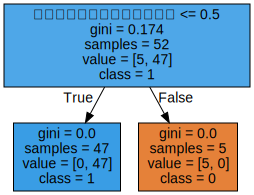

In [38]:
filter_tree("聲因1 == 1 | 聲因2 == 1")

## 8.3.6 聲因 All 0

----------------------------------------------------------------------------------------------------
Filter 聲因1 == 0 & 聲因2 == 0 & 聲因3 == 0 & 聲因4 == 0 & 聲因5 == 0 & 聲因6 == 0 & 聲因7 == 0 & 聲因8 == 0 & 聲因9 == 0 len = 22
----------------------------------------------------------------------------------------------------
x ['法院是否認為原監護輔助人「身體不堪負荷」', '法院是否認為原監護輔助人「盜領存款」', '法院是否認為原監護輔助人「不當處理本人之不動產」', '法院是否認為原監護輔助人「與本人有利害關係」', '法院是否認為原監護輔助人有「其他不當行為」', '法院是否認為原監護輔助人是「本人之實際照顧者」', '法院是否認為監護人現為本人廣義照顧者', '原監護輔助人是否有意願續任', '專業人士訪視報告之「改定建議」', '本人之「改定建議」', '其他親屬、關係人之「改定建議」']
y 原監護輔助人是否被法院改定
預測 [0 0 0 0 0]
標準答案 [0 0 0 0 0]
績效 1.0
|--- feature_1 <= 0.50
|   |--- class: 0
|--- feature_1 >  0.50
|   |--- class: 1



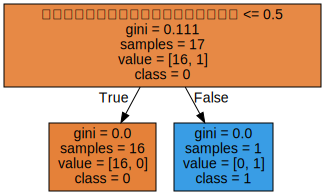

In [39]:
filter_tree("聲因1 == 0 & 聲因2 == 0 & 聲因3 == 0 & 聲因4 == 0 & 聲因5 == 0 & 聲因6 == 0 & 聲因7 == 0 & 聲因8 == 0 & 聲因9 == 0")

## 8.4 所有共線


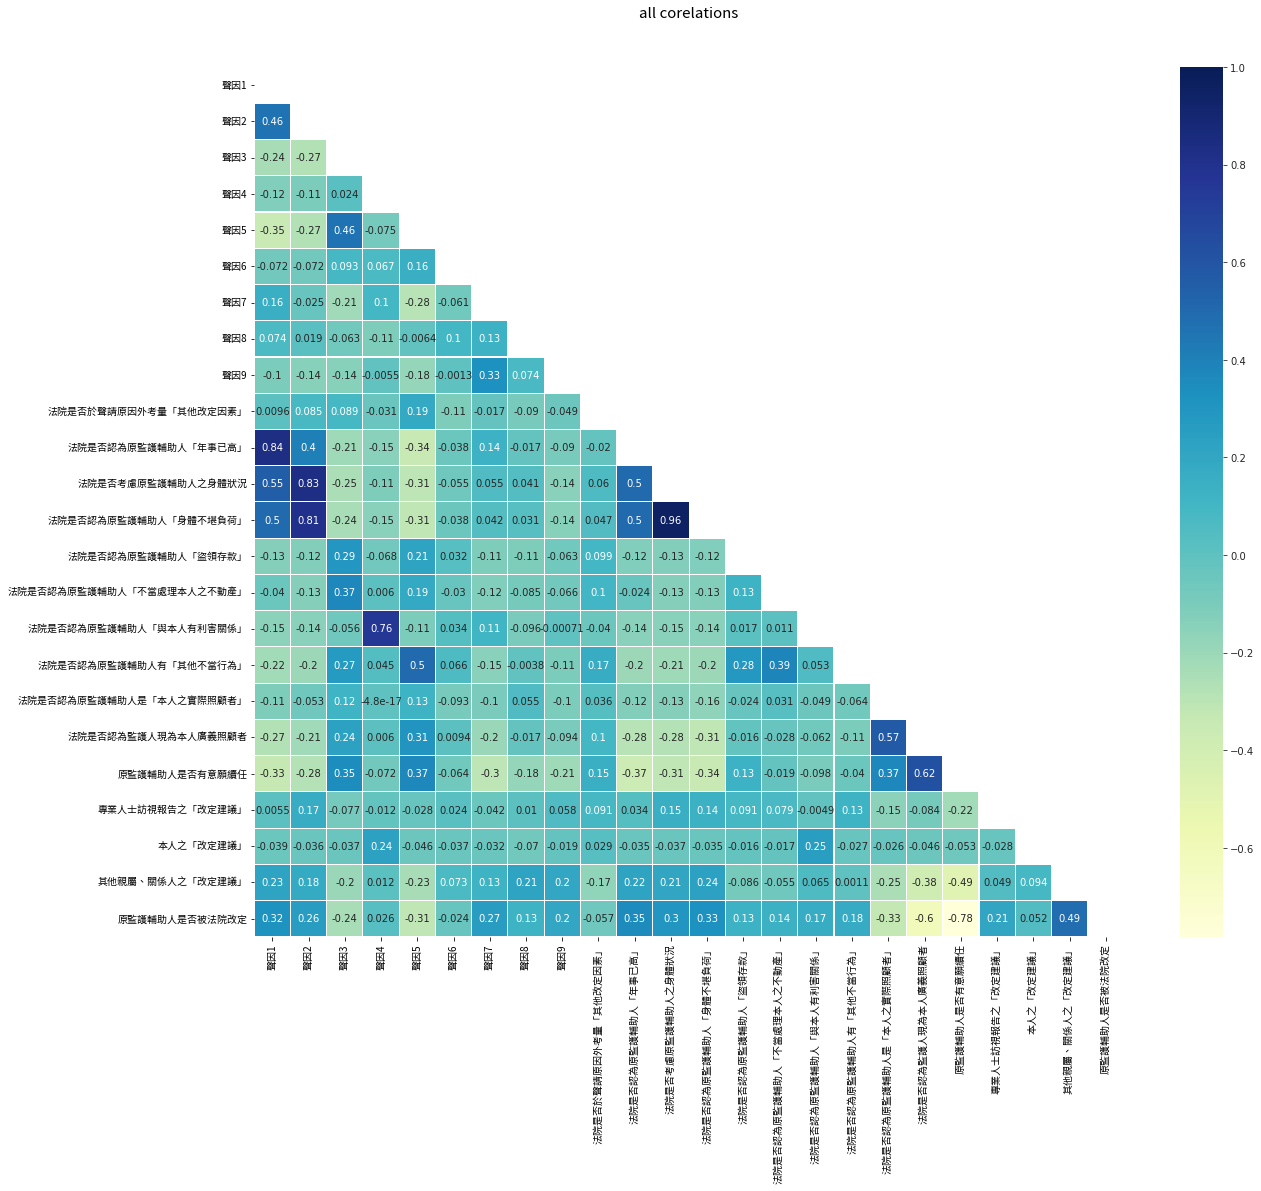

In [24]:
cc = Corr(gsheet_id, gsheet_name, to_drop=[
  'index',
  'UUID',
  #'聲因1',
  #'聲因2',
  #'聲因3',
  #'聲因4',
  #'聲因5',
  #'聲因6',
  #'聲因7',
  #'聲因8',
  #'聲因9',
  '宣告性質',
  '原監護輔助人之類型',
  '原監護輔助人之人數（自然人）',
  '主管機關是否被法院改定 (1=是, 2=否)',
  #'法院是否於聲請原因外考量「其他改定因素」',
  #'法院是否認為原監護輔助人「年事已高」',
  #'法院是否考慮原監護輔助人之身體狀況',
  #'法院是否認為原監護輔助人「身體不堪負荷」',
  #'法院是否認為原監護輔助人「盜領存款」',
  #'法院是否認為原監護輔助人「不當處理本人之不動產」',
  #'原監護輔助人是否與本人有「利害關係」',
  #'法院是否認為原監護輔助人有「其他不當行為」',
  #'法院是否認為原監護輔助人是「本人之實際照顧者」',
  #'監護輔助人是否為本人「廣義照顧者」',
  #'原監護輔助人是否有意願續任',
  #'專業人士訪視報告之「改定建議」',
  #'本人之「改定建議」',
  #'其他親屬、關係人之「改定建議」',
  #'原監護輔助人是否被法院改定',
])
for col in cc.df.columns:
  cc.replace_col_to(col, '', 0)
cc.convert_to_numeric()
cc.corr_heatmap()

# 8. 需要分析內容 (輔助宣告)


In [40]:
gsheet_name = gsheet_name3

## 8.1 馬賽克


25
Index(['聲因1', '聲因2', '聲因3', '聲因4', '聲因5', '聲因6', '聲因7', '聲因8', '聲因9',
       '原監護輔助人之人數（自然人）', '法院是否於聲請原因外考量「其他改定因素」', '法院是否認為原監護輔助人「年事已高」',
       '法院是否考慮原監護輔助人之身體狀況', '法院是否認為原監護輔助人「身體不堪負荷」', '法院是否認為原監護輔助人「盜領存款」',
       '法院是否認為原監護輔助人「不當處理本人之不動產」', '法院是否認為原監護輔助人「與本人有利害關係」',
       '法院是否認為原監護輔助人有「其他不當行為」', '法院是否認為原監護輔助人是「本人之實際照顧者」',
       '法院是否認為監護人現為本人廣義照顧者', '原監護輔助人是否有意願續任', '專業人士訪視報告之「改定建議」', '本人之「改定建議」',
       '其他親屬、關係人之「改定建議」', '原監護輔助人是否被法院改定'],
      dtype='object')
聲因1
0    84
1    15
Name: 聲因1, dtype: int64
--------------------------------------------------
聲因2
0    82
1    17
Name: 聲因2, dtype: int64
--------------------------------------------------
聲因3
0    78
1    21
Name: 聲因3, dtype: int64
--------------------------------------------------
聲因4
0    87
1    12
Name: 聲因4, dtype: int64
--------------------------------------------------
聲因5
0    77
1    22
Name: 聲因5, dtype: int64
--------------------------------------------------
聲因6
0    71
1    28
Name: 聲因6, dtype: int64

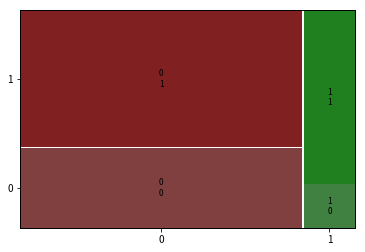




--------------------------------------------------
X 軸 = 聲因2
Y 軸 = 原監護輔助人是否被法院改定
--------------------------------------------------
原監護輔助人是否被法院改定   0   1
聲因2                  
0              31  51
1               3  14
p value is 0.11117614060681431
兩者無關 Independent (H0 holds true)


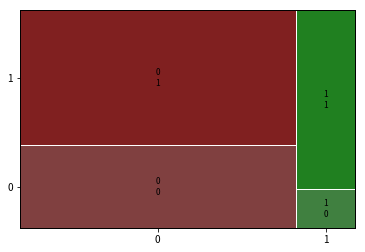




--------------------------------------------------
X 軸 = 聲因3
Y 軸 = 原監護輔助人是否被法院改定
--------------------------------------------------
原監護輔助人是否被法院改定   0   1
聲因3                  
0              25  53
1               9  12
p value is 0.3546379024518461
兩者無關 Independent (H0 holds true)


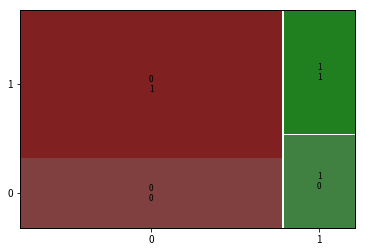




--------------------------------------------------
X 軸 = 聲因4
Y 軸 = 原監護輔助人是否被法院改定
--------------------------------------------------
原監護輔助人是否被法院改定   0   1
聲因4                  
0              31  56
1               3   9
p value is 0.46716465233283255
兩者無關 Independent (H0 holds true)


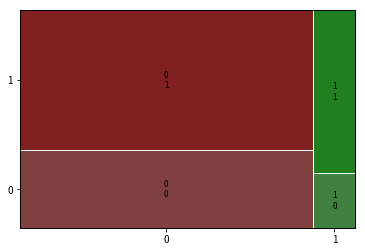




--------------------------------------------------
X 軸 = 聲因5
Y 軸 = 原監護輔助人是否被法院改定
--------------------------------------------------
原監護輔助人是否被法院改定   0   1
聲因5                  
0              22  55
1              12  10
p value is 0.023657255947106624
兩者有關 Dependent (reject H0)


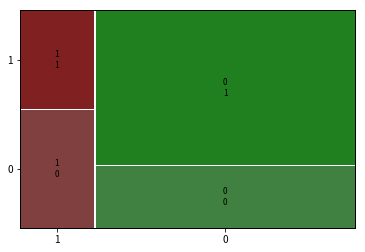




--------------------------------------------------
X 軸 = 聲因6
Y 軸 = 原監護輔助人是否被法院改定
--------------------------------------------------
原監護輔助人是否被法院改定   0   1
聲因6                  
0              27  44
1               7  21
p value is 0.21890083871841726
兩者無關 Independent (H0 holds true)


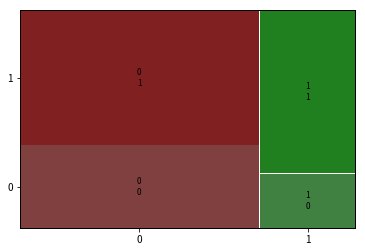




--------------------------------------------------
X 軸 = 聲因7
Y 軸 = 原監護輔助人是否被法院改定
--------------------------------------------------
原監護輔助人是否被法院改定   0   1
聲因7                  
0              33  50
1               1  15
p value is 0.009751037994224145
兩者有關 Dependent (reject H0)


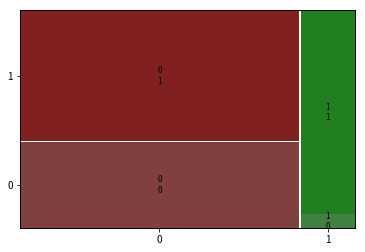




--------------------------------------------------
X 軸 = 聲因8
Y 軸 = 原監護輔助人是否被法院改定
--------------------------------------------------
原監護輔助人是否被法院改定   0   1
聲因8                  
0              16  29
1              18  36
p value is 0.8166524542108818
兩者無關 Independent (H0 holds true)


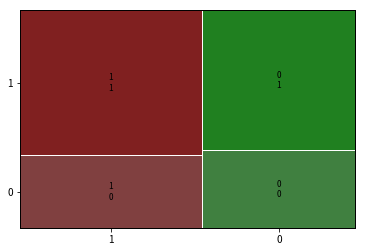




--------------------------------------------------
X 軸 = 聲因9
Y 軸 = 原監護輔助人是否被法院改定
--------------------------------------------------
原監護輔助人是否被法院改定   0   1
聲因9                  
0              32  54
1               2  11
p value is 0.12246512284065846
兩者無關 Independent (H0 holds true)


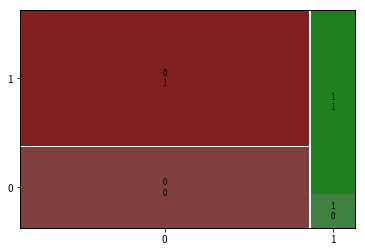




--------------------------------------------------
X 軸 = 原監護輔助人之人數（自然人）
Y 軸 = 原監護輔助人是否被法院改定
--------------------------------------------------
原監護輔助人是否被法院改定    0   1
原監護輔助人之人數（自然人）        
1               17  46
2               16  10
3                0   3
7                1   6
p value is 0.004951611512971072
兩者有關 Dependent (reject H0)


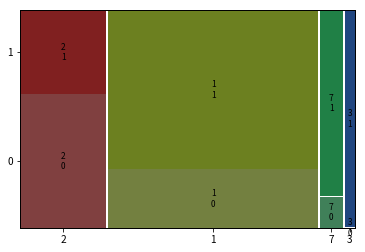




--------------------------------------------------
X 軸 = 法院是否於聲請原因外考量「其他改定因素」
Y 軸 = 原監護輔助人是否被法院改定
--------------------------------------------------
原監護輔助人是否被法院改定          0   1
法院是否於聲請原因外考量「其他改定因素」        
0                      9  18
1                     25  47
p value is 0.8968753255597335
兩者無關 Independent (H0 holds true)


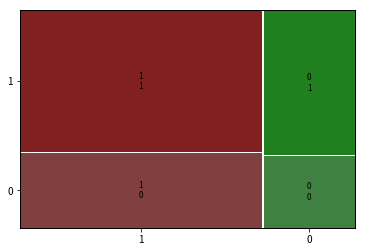




--------------------------------------------------
X 軸 = 法院是否認為原監護輔助人「年事已高」
Y 軸 = 原監護輔助人是否被法院改定
--------------------------------------------------
原監護輔助人是否被法院改定        0   1
法院是否認為原監護輔助人「年事已高」        
0                   32  54
1                    2  11
p value is 0.12246512284065846
兩者無關 Independent (H0 holds true)


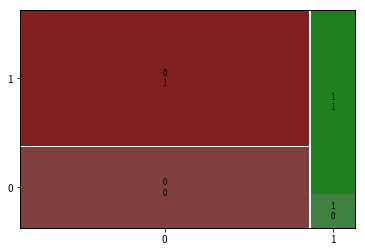




--------------------------------------------------
X 軸 = 法院是否考慮原監護輔助人之身體狀況
Y 軸 = 原監護輔助人是否被法院改定
--------------------------------------------------
原監護輔助人是否被法院改定       0   1
法院是否考慮原監護輔助人之身體狀況        
0                  32  50
1                   2  15
p value is 0.03122929362870151
兩者有關 Dependent (reject H0)


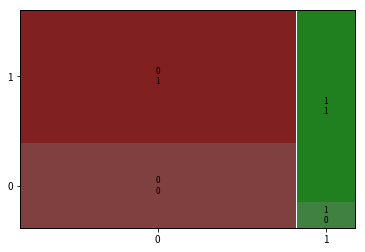




--------------------------------------------------
X 軸 = 法院是否認為原監護輔助人「身體不堪負荷」
Y 軸 = 原監護輔助人是否被法院改定
--------------------------------------------------
原監護輔助人是否被法院改定          0   1
法院是否認為原監護輔助人「身體不堪負荷」        
0                     34  53
1                      0  12
p value is 0.007526951319670264
兩者有關 Dependent (reject H0)


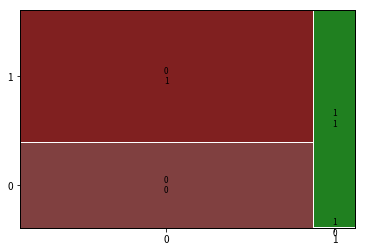




--------------------------------------------------
X 軸 = 法院是否認為原監護輔助人「盜領存款」
Y 軸 = 原監護輔助人是否被法院改定
--------------------------------------------------
原監護輔助人是否被法院改定        0   1
法院是否認為原監護輔助人「盜領存款」        
0                   34  61
1                    0   4
p value is 0.13977768789706121
兩者無關 Independent (H0 holds true)


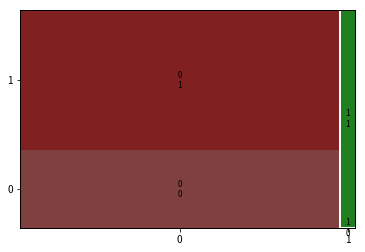




--------------------------------------------------
X 軸 = 法院是否認為原監護輔助人「不當處理本人之不動產」
Y 軸 = 原監護輔助人是否被法院改定
--------------------------------------------------
原監護輔助人是否被法院改定              0   1
法院是否認為原監護輔助人「不當處理本人之不動產」        
0                         34  62
1                          0   3
p value is 0.20333328760444314
兩者無關 Independent (H0 holds true)


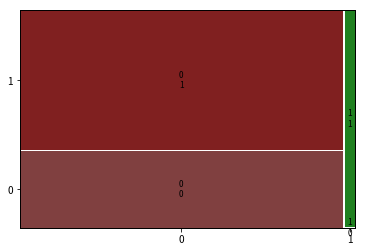




--------------------------------------------------
X 軸 = 法院是否認為原監護輔助人「與本人有利害關係」
Y 軸 = 原監護輔助人是否被法院改定
--------------------------------------------------
原監護輔助人是否被法院改定            0   1
法院是否認為原監護輔助人「與本人有利害關係」        
0                       34  57
1                        0   8
p value is 0.032870840234422674
兩者有關 Dependent (reject H0)


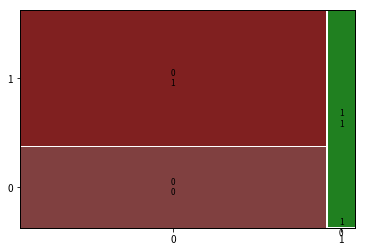




--------------------------------------------------
X 軸 = 法院是否認為原監護輔助人有「其他不當行為」
Y 軸 = 原監護輔助人是否被法院改定
--------------------------------------------------
原監護輔助人是否被法院改定           0   1
法院是否認為原監護輔助人有「其他不當行為」        
0                      32  44
1                       2  21
p value is 0.0031125039683490034
兩者有關 Dependent (reject H0)


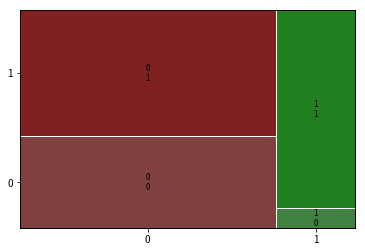




--------------------------------------------------
X 軸 = 法院是否認為原監護輔助人是「本人之實際照顧者」
Y 軸 = 原監護輔助人是否被法院改定
--------------------------------------------------
原監護輔助人是否被法院改定             0   1
法院是否認為原監護輔助人是「本人之實際照顧者」        
0                        29  63
1                         5   2
p value is 0.032077657775603605
兩者有關 Dependent (reject H0)


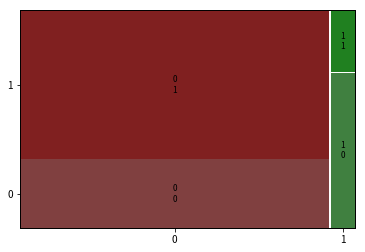




--------------------------------------------------
X 軸 = 法院是否認為監護人現為本人廣義照顧者
Y 軸 = 原監護輔助人是否被法院改定
--------------------------------------------------
原監護輔助人是否被法院改定        0   1
法院是否認為監護人現為本人廣義照顧者        
0                   21  60
1                   13   5
p value is 0.00018292065104885688
兩者有關 Dependent (reject H0)


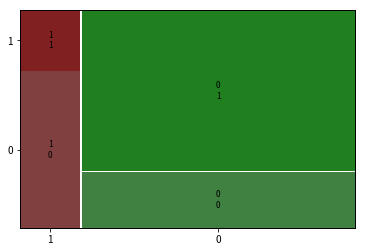




--------------------------------------------------
X 軸 = 原監護輔助人是否有意願續任
Y 軸 = 原監護輔助人是否被法院改定
--------------------------------------------------
原監護輔助人是否被法院改定   0   1
原監護輔助人是否有意願續任        
0               8  51
1              26  14
p value is 1.2290030570707607e-07
兩者有關 Dependent (reject H0)


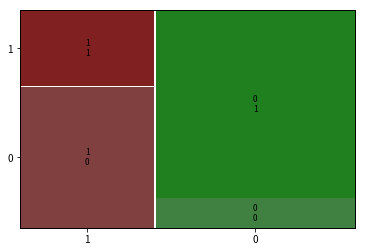




--------------------------------------------------
X 軸 = 專業人士訪視報告之「改定建議」
Y 軸 = 原監護輔助人是否被法院改定
--------------------------------------------------
原監護輔助人是否被法院改定     0   1
專業人士訪視報告之「改定建議」        
0                33  50
1                 1  15
p value is 0.009751037994224145
兩者有關 Dependent (reject H0)


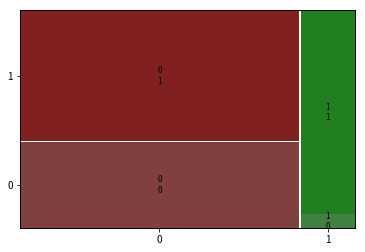




--------------------------------------------------
X 軸 = 本人之「改定建議」
Y 軸 = 原監護輔助人是否被法院改定
--------------------------------------------------
原監護輔助人是否被法院改定   0   1
本人之「改定建議」            
0              32  40
1               2  25
p value is 0.0005477360805479631
兩者有關 Dependent (reject H0)


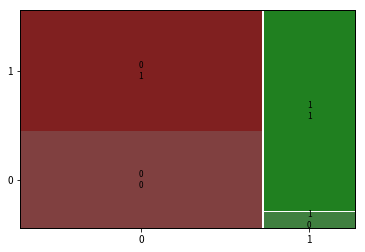




--------------------------------------------------
X 軸 = 其他親屬、關係人之「改定建議」
Y 軸 = 原監護輔助人是否被法院改定
--------------------------------------------------
原監護輔助人是否被法院改定     0   1
其他親屬、關係人之「改定建議」        
0                32  32
1                 2  33
p value is 9.156944541979785e-06
兩者有關 Dependent (reject H0)


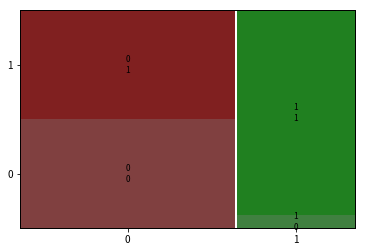

In [53]:
k = Corr(gsheet_id, gsheet_name, to_drop=[
  'index',
  'UUID',
  '主管機關是否被法院改定 (1=是, 2=否)',
  '宣告性質',
  '原監護輔助人之類型'
])
for col in k.df.columns:
  k.replace_col_to(col, '', 0) # 替換 '' to -100 因為決策樹不支援 NaN
k.convert_to_numeric()
k.print_value_counts()

for i in range(0, 24):
  if i == 24:
    break
  print(f"\n\n")
  k.chi2_contingency_and_mosaic(k.cols()[i], '原監護輔助人是否被法院改定')

## 8.2.1 PCA 聲因1-9

                    PC0       PC1       PC2       PC3       PC4       PC5  \
聲因1           -0.137121  0.565361  0.229720  0.097203 -0.242753  0.152429   
聲因2           -0.162579  0.533406  0.307348  0.003785 -0.138400  0.168646   
聲因3            0.521262 -0.104296  0.252839  0.033394 -0.202614 -0.284323   
聲因4            0.139852 -0.133959  0.451494  0.417902  0.562546  0.262499   
聲因5            0.521309 -0.022637  0.092746 -0.323923 -0.195210 -0.048826   
聲因6            0.111496 -0.171054  0.570710 -0.353755 -0.153135  0.343445   
聲因7           -0.374527 -0.396965  0.206904 -0.144735  0.133041  0.138047   
聲因8           -0.077033  0.213462 -0.056736 -0.744329  0.473867 -0.037591   
聲因9           -0.357268 -0.365839  0.015424 -0.098672 -0.510162  0.172346   
原監護輔助人是否被法院改定 -0.324737 -0.016269  0.452122  0.001229  0.018295 -0.792507   

                    PC6       PC7       PC8       PC9  
聲因1           -0.029764 -0.399313 -0.227731 -0.552253  
聲因2            0.383452  0.272490  0.319

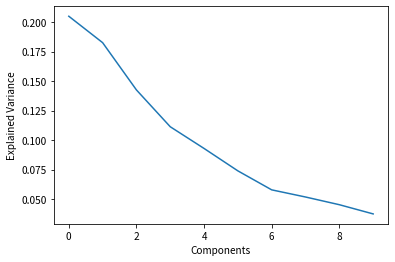

In [ ]:
p = Corr(gsheet_id, gsheet_name, to_drop=[
  'index',
  'UUID',
  #'聲因1',
  #'聲因2',
  #'聲因3',
  #'聲因4',
  #'聲因5',
  #'聲因6',
  #'聲因7',
  #'聲因8',
  #'聲因9',
  '宣告性質',
  '原監護輔助人之類型',
  '原監護輔助人之人數（自然人）',
  '主管機關是否被法院改定 (1=是, 2=否)',
  '法院是否於聲請原因外考量「其他改定因素」',
  '法院是否認為原監護輔助人「年事已高」',
  '法院是否考慮原監護輔助人之身體狀況',
  '法院是否認為原監護輔助人「身體不堪負荷」',
  '法院是否認為原監護輔助人「盜領存款」',
  '法院是否認為原監護輔助人「不當處理本人之不動產」',
  '原監護輔助人是否與本人有「利害關係」',
  '法院是否認為原監護輔助人有「其他不當行為」',
  '法院是否認為原監護輔助人是「本人之實際照顧者」',
  '監護輔助人是否為本人「廣義照顧者」',
  '原監護輔助人是否有意願續任',
  '專業人士訪視報告之「改定建議」',
  '本人之「改定建議」',
  '其他親屬、關係人之「改定建議」',
  #'原監護輔助人是否被法院改定'
])
p.convert_to_numeric()
p.pca()

0 聲因1
9 原監護輔助人是否被法院改定
   原監護輔助人是否被法院改定       聲因1
0       0.590489 -0.752616
1       0.071168 -0.646413
2      -0.612924 -0.555041
3      -0.261069 -0.008247
4      -0.784786 -0.782042


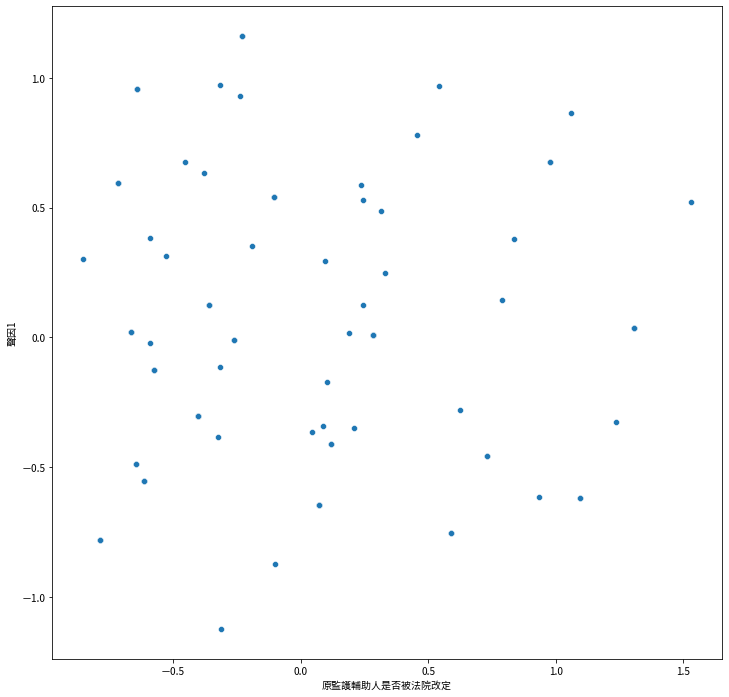

In [ ]:
p.pca2(p.col(0), p.col(9))

## 8.2.2 PCA Filter 聲因

----------------------------------------------------------------------------------------------------
Filter 聲因1 99
Dropping ['聲因1', '聲因2', '聲因3', '聲因4', '聲因5', '聲因6', '聲因7', '聲因8', '聲因9']
----------------------------------------------------------------------------------------------------
                               PC0       PC1       PC2       PC3       PC4  \
法院是否於聲請原因外考量「其他改定因素」      0.107999 -0.176535 -0.041146  0.021686  0.707591   
法院是否認為原監護輔助人「年事已高」        0.393003  0.295461  0.044644 -0.030248  0.015629   
法院是否考慮原監護輔助人之身體狀況         0.426147  0.342069  0.148619 -0.126817  0.142266   
法院是否認為原監護輔助人「身體不堪負荷」      0.414928  0.348731  0.158181 -0.139867  0.080087   
法院是否認為原監護輔助人「盜領存款」       -0.324000  0.301542  0.298390 -0.068574 -0.181229   
法院是否認為原監護輔助人「不當處理本人之不動產」 -0.172841  0.011105  0.461051 -0.127189  0.269966   
法院是否認為原監護輔助人「與本人有利害關係」   -0.106052 -0.195570  0.514167  0.021817  0.090366   
法院是否認為原監護輔助人有「其他不當行為」    -0.338628  0.196501  0.353465 -0.094487  0.053093   
法院是否認為原監護

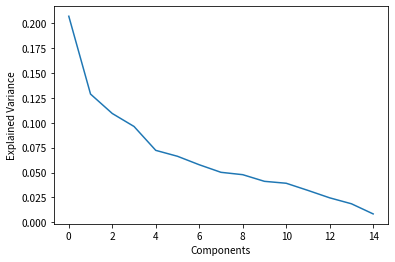

1 法院是否認為原監護輔助人「年事已高」
   原監護輔助人是否被法院改定  法院是否認為原監護輔助人「年事已高」
0    -706.863042         -159.693603
1     185.558888         -150.049382
2    1337.179011         -100.910859
3    -326.116385          556.460424
4     589.686722         -615.747333


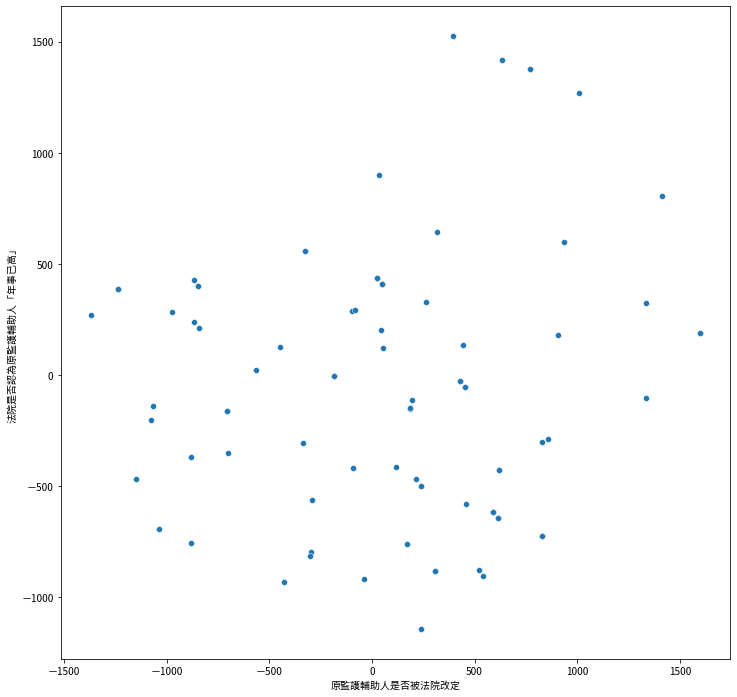

In [ ]:
for i in range(1, 10):
  p = Corr(gsheet_id, gsheet_name, to_drop=[
    'index',
    'UUID',
    '宣告性質',
    '原監護輔助人之類型',
    '原監護輔助人之人數（自然人）',
    '主管機關是否被法院改定 (1=是, 2=否)',
  ])
  for col in p.df.columns:
    p.replace_col_to(col, '', -1000) # 替換 '' to -100 因為決策樹不支援 NaN
  p.convert_to_numeric()
  print('-'*100)
  print(f"Filter 聲因{str(i)} {len(p.df)}")
  print(f"Dropping {p.cols()[0:9]}")
  print('-'*100)
  p.drop(p.cols()[0:9])
  p.pca()
  p.pca2(p.col(1), '原監護輔助人是否被法院改定')
  break

## 8.3.1 決策樹1

x ['聲因1', '聲因2', '聲因3', '聲因4', '聲因5', '聲因6', '聲因7', '聲因8', '聲因9']
y 原監護輔助人是否被法院改定
預測 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
標準答案 [0 1 1 0 1 1 1 1 1 1 1 0 1 1 1 0 1 0 0 1]
績效 0.7
|--- feature_6 <= 0.50
|   |--- feature_1 <= 0.50
|   |   |--- class: 1
|   |--- feature_1 >  0.50
|   |   |--- class: 1
|--- feature_6 >  0.50
|   |--- feature_1 <= 0.50
|   |   |--- class: 1
|   |--- feature_1 >  0.50
|   |   |--- class: 0



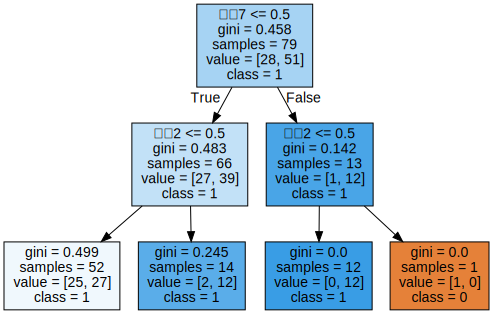

In [42]:
dt = DecisionTree(gsheet_id, gsheet_name, auto_proc=True, to_drop=[
  'index',
  'UUID',
  '主管機關是否被法院改定 (1=是, 2=否)',
  '宣告性質',
  '原監護輔助人之類型'
])
dt.convert_to_numeric()
dt.load(dt.cols()[0:9], '原監護輔助人是否被法院改定', binary_y=True)
dt.text_representation()
dt.graph()

25
Index(['聲因1', '聲因2', '聲因3', '聲因4', '聲因5', '聲因6', '聲因7', '聲因8', '聲因9',
       '原監護輔助人之人數（自然人）', '法院是否於聲請原因外考量「其他改定因素」', '法院是否認為原監護輔助人「年事已高」',
       '法院是否考慮原監護輔助人之身體狀況', '法院是否認為原監護輔助人「身體不堪負荷」', '法院是否認為原監護輔助人「盜領存款」',
       '法院是否認為原監護輔助人「不當處理本人之不動產」', '法院是否認為原監護輔助人「與本人有利害關係」',
       '法院是否認為原監護輔助人有「其他不當行為」', '法院是否認為原監護輔助人是「本人之實際照顧者」',
       '法院是否認為監護人現為本人廣義照顧者', '原監護輔助人是否有意願續任', '專業人士訪視報告之「改定建議」', '本人之「改定建議」',
       '其他親屬、關係人之「改定建議」', '原監護輔助人是否被法院改定'],
      dtype='object')
聲因1
0    84
1    15
Name: 聲因1, dtype: int64
--------------------------------------------------
聲因2
0    82
1    17
Name: 聲因2, dtype: int64
--------------------------------------------------
聲因3
0    78
1    21
Name: 聲因3, dtype: int64
--------------------------------------------------
聲因4
0    87
1    12
Name: 聲因4, dtype: int64
--------------------------------------------------
聲因5
0    77
1    22
Name: 聲因5, dtype: int64
--------------------------------------------------
聲因6
0    71
1    28
Name: 聲因6, dtype: int64

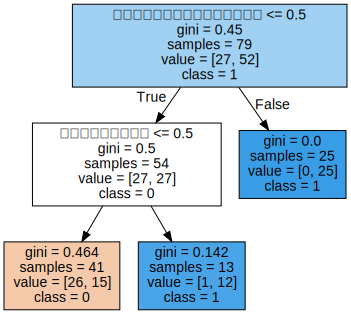

In [44]:
dt2 = DecisionTree(gsheet_id, gsheet_name, auto_proc=True, to_drop=[
  'index',
  'UUID',
  '主管機關是否被法院改定 (1=是, 2=否)',
  '宣告性質',
  '原監護輔助人之類型'
])
for col in dt2.df.columns:
  dt2.replace_col_to(col, '', 0) # 替換 '' to -100 因為決策樹不支援 NaN
dt2.convert_to_numeric()
dt2.print_value_counts()
dt2.load(dt2.cols()[13:24], '原監護輔助人是否被法院改定', binary_y=True)
dt2.text_representation()
dt2.graph()

25
Index(['聲因1', '聲因2', '聲因3', '聲因4', '聲因5', '聲因6', '聲因7', '聲因8', '聲因9',
       '原監護輔助人之人數（自然人）', '法院是否於聲請原因外考量「其他改定因素」', '法院是否認為原監護輔助人「年事已高」',
       '法院是否考慮原監護輔助人之身體狀況', '法院是否認為原監護輔助人「身體不堪負荷」', '法院是否認為原監護輔助人「盜領存款」',
       '法院是否認為原監護輔助人「不當處理本人之不動產」', '法院是否認為原監護輔助人「與本人有利害關係」',
       '法院是否認為原監護輔助人有「其他不當行為」', '法院是否認為原監護輔助人是「本人之實際照顧者」',
       '法院是否認為監護人現為本人廣義照顧者', '原監護輔助人是否有意願續任', '專業人士訪視報告之「改定建議」', '本人之「改定建議」',
       '其他親屬、關係人之「改定建議」', '原監護輔助人是否被法院改定'],
      dtype='object')
聲因1
0    84
1    15
Name: 聲因1, dtype: int64
--------------------------------------------------
聲因2
0    82
1    17
Name: 聲因2, dtype: int64
--------------------------------------------------
聲因3
0    78
1    21
Name: 聲因3, dtype: int64
--------------------------------------------------
聲因4
0    87
1    12
Name: 聲因4, dtype: int64
--------------------------------------------------
聲因5
0    77
1    22
Name: 聲因5, dtype: int64
--------------------------------------------------
聲因6
0    71
1    28
Name: 聲因6, dtype: int64

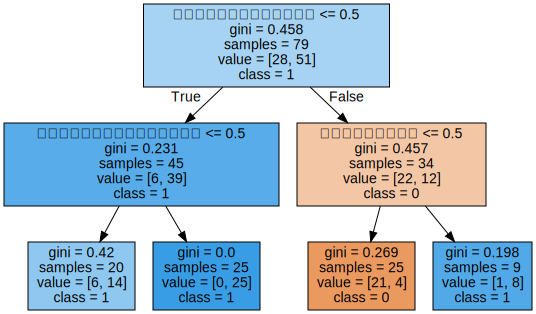

In [46]:
dt2 = DecisionTree(gsheet_id, gsheet_name, auto_proc=True, to_drop=[
  'index',
  'UUID',
  '主管機關是否被法院改定 (1=是, 2=否)',
  '宣告性質',
  '原監護輔助人之類型'
])
for col in dt2.df.columns:
  dt2.replace_col_to(col, '', 0) # 替換 '' to -100 因為決策樹不支援 NaN
dt2.convert_to_numeric()
dt2.print_value_counts()
dt2.load(dt2.cols()[13:24], '原監護輔助人是否被法院改定', binary_y=True)
dt2.text_representation()
dt2.graph()

## 8.3.2 決策樹 Filter 聲因 1-9

----------------------------------------------------------------------------------------------------
Filter 聲因1 == 1 len = 15
----------------------------------------------------------------------------------------------------
x ['法院是否認為原監護輔助人「身體不堪負荷」', '法院是否認為原監護輔助人「盜領存款」', '法院是否認為原監護輔助人「不當處理本人之不動產」', '法院是否認為原監護輔助人「與本人有利害關係」', '法院是否認為原監護輔助人有「其他不當行為」', '法院是否認為原監護輔助人是「本人之實際照顧者」', '法院是否認為監護人現為本人廣義照顧者', '原監護輔助人是否有意願續任', '專業人士訪視報告之「改定建議」', '本人之「改定建議」', '其他親屬、關係人之「改定建議」']
y 原監護輔助人是否被法院改定
預測 [0 1 1]
標準答案 [1 1 1]
績效 0.6666666666666666
|--- feature_0 <= 0.50
|   |--- feature_9 <= 0.50
|   |   |--- class: 0
|   |--- feature_9 >  0.50
|   |   |--- class: 1
|--- feature_0 >  0.50
|   |--- class: 1



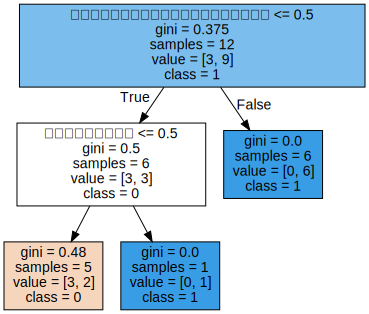

----------------------------------------------------------------------------------------------------
Filter 聲因2 == 1 len = 17
----------------------------------------------------------------------------------------------------
x ['法院是否認為原監護輔助人「身體不堪負荷」', '法院是否認為原監護輔助人「盜領存款」', '法院是否認為原監護輔助人「不當處理本人之不動產」', '法院是否認為原監護輔助人「與本人有利害關係」', '法院是否認為原監護輔助人有「其他不當行為」', '法院是否認為原監護輔助人是「本人之實際照顧者」', '法院是否認為監護人現為本人廣義照顧者', '原監護輔助人是否有意願續任', '專業人士訪視報告之「改定建議」', '本人之「改定建議」', '其他親屬、關係人之「改定建議」']
y 原監護輔助人是否被法院改定
預測 [1 1 1 1]
標準答案 [1 1 1 1]
績效 1.0
|--- feature_7 <= 0.50
|   |--- feature_10 <= 0.50
|   |   |--- class: 1
|   |--- feature_10 >  0.50
|   |   |--- class: 1
|--- feature_7 >  0.50
|   |--- class: 0



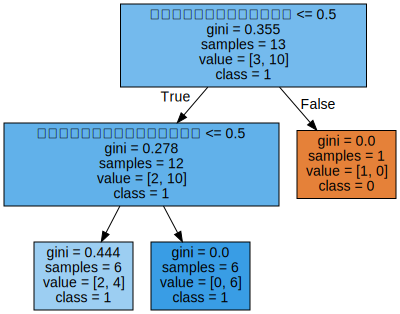

----------------------------------------------------------------------------------------------------
Filter 聲因3 == 1 len = 21
----------------------------------------------------------------------------------------------------
x ['法院是否認為原監護輔助人「身體不堪負荷」', '法院是否認為原監護輔助人「盜領存款」', '法院是否認為原監護輔助人「不當處理本人之不動產」', '法院是否認為原監護輔助人「與本人有利害關係」', '法院是否認為原監護輔助人有「其他不當行為」', '法院是否認為原監護輔助人是「本人之實際照顧者」', '法院是否認為監護人現為本人廣義照顧者', '原監護輔助人是否有意願續任', '專業人士訪視報告之「改定建議」', '本人之「改定建議」', '其他親屬、關係人之「改定建議」']
y 原監護輔助人是否被法院改定
預測 [0 1 0 0 0]
標準答案 [0 1 0 1 0]
績效 0.8
|--- feature_4 <= 0.50
|   |--- feature_8 <= 0.50
|   |   |--- class: 0
|   |--- feature_8 >  0.50
|   |   |--- class: 1
|--- feature_4 >  0.50
|   |--- feature_8 <= 0.50
|   |   |--- class: 1
|   |--- feature_8 >  0.50
|   |   |--- class: 1



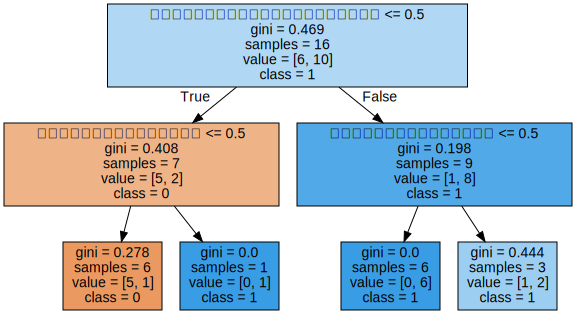

----------------------------------------------------------------------------------------------------
Filter 聲因4 == 1 len = 12
----------------------------------------------------------------------------------------------------
x ['法院是否認為原監護輔助人「身體不堪負荷」', '法院是否認為原監護輔助人「盜領存款」', '法院是否認為原監護輔助人「不當處理本人之不動產」', '法院是否認為原監護輔助人「與本人有利害關係」', '法院是否認為原監護輔助人有「其他不當行為」', '法院是否認為原監護輔助人是「本人之實際照顧者」', '法院是否認為監護人現為本人廣義照顧者', '原監護輔助人是否有意願續任', '專業人士訪視報告之「改定建議」', '本人之「改定建議」', '其他親屬、關係人之「改定建議」']
y 原監護輔助人是否被法院改定
預測 [1 0 1]
標準答案 [0 1 0]
績效 0.0
|--- feature_10 <= 0.50
|   |--- class: 1
|--- feature_10 >  0.50
|   |--- feature_9 <= 0.50
|   |   |--- class: 0
|   |--- feature_9 >  0.50
|   |   |--- class: 1



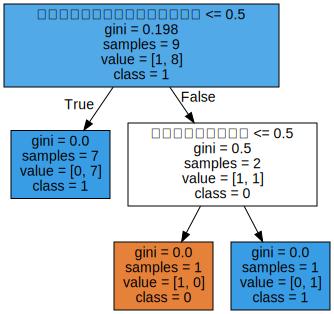

----------------------------------------------------------------------------------------------------
Filter 聲因5 == 1 len = 22
----------------------------------------------------------------------------------------------------
x ['法院是否認為原監護輔助人「身體不堪負荷」', '法院是否認為原監護輔助人「盜領存款」', '法院是否認為原監護輔助人「不當處理本人之不動產」', '法院是否認為原監護輔助人「與本人有利害關係」', '法院是否認為原監護輔助人有「其他不當行為」', '法院是否認為原監護輔助人是「本人之實際照顧者」', '法院是否認為監護人現為本人廣義照顧者', '原監護輔助人是否有意願續任', '專業人士訪視報告之「改定建議」', '本人之「改定建議」', '其他親屬、關係人之「改定建議」']
y 原監護輔助人是否被法院改定
預測 [0 1 0 0 1]
標準答案 [1 1 0 0 1]
績效 0.8
|--- feature_9 <= 0.50
|   |--- feature_8 <= 0.50
|   |   |--- class: 0
|   |--- feature_8 >  0.50
|   |   |--- class: 1
|--- feature_9 >  0.50
|   |--- feature_8 <= 0.50
|   |   |--- class: 1
|   |--- feature_8 >  0.50
|   |   |--- class: 1



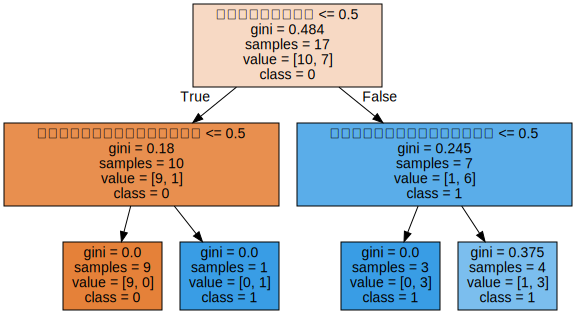

----------------------------------------------------------------------------------------------------
Filter 聲因6 == 1 len = 28
----------------------------------------------------------------------------------------------------
x ['法院是否認為原監護輔助人「身體不堪負荷」', '法院是否認為原監護輔助人「盜領存款」', '法院是否認為原監護輔助人「不當處理本人之不動產」', '法院是否認為原監護輔助人「與本人有利害關係」', '法院是否認為原監護輔助人有「其他不當行為」', '法院是否認為原監護輔助人是「本人之實際照顧者」', '法院是否認為監護人現為本人廣義照顧者', '原監護輔助人是否有意願續任', '專業人士訪視報告之「改定建議」', '本人之「改定建議」', '其他親屬、關係人之「改定建議」']
y 原監護輔助人是否被法院改定
預測 [1 1 1 1 1 1]
標準答案 [1 0 1 0 1 1]
績效 0.6666666666666666
|--- feature_9 <= 0.50
|   |--- feature_6 <= 0.50
|   |   |--- class: 1
|   |--- feature_6 >  0.50
|   |   |--- class: 0
|--- feature_9 >  0.50
|   |--- feature_8 <= 0.50
|   |   |--- class: 1
|   |--- feature_8 >  0.50
|   |   |--- class: 1



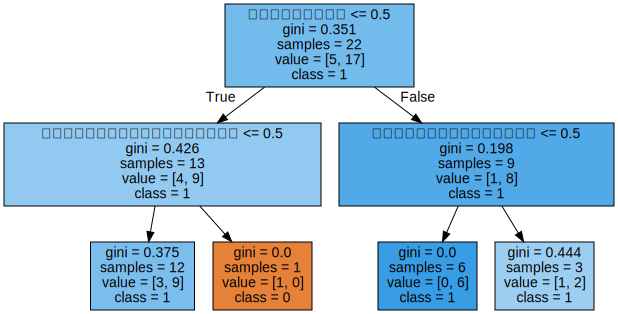

----------------------------------------------------------------------------------------------------
Filter 聲因7 == 1 len = 16
----------------------------------------------------------------------------------------------------
x ['法院是否認為原監護輔助人「身體不堪負荷」', '法院是否認為原監護輔助人「盜領存款」', '法院是否認為原監護輔助人「不當處理本人之不動產」', '法院是否認為原監護輔助人「與本人有利害關係」', '法院是否認為原監護輔助人有「其他不當行為」', '法院是否認為原監護輔助人是「本人之實際照顧者」', '法院是否認為監護人現為本人廣義照顧者', '原監護輔助人是否有意願續任', '專業人士訪視報告之「改定建議」', '本人之「改定建議」', '其他親屬、關係人之「改定建議」']
y 原監護輔助人是否被法院改定
預測 [1 1 0 1]
標準答案 [1 1 1 1]
績效 0.75
|--- feature_6 <= 0.50
|   |--- class: 1
|--- feature_6 >  0.50
|   |--- class: 0



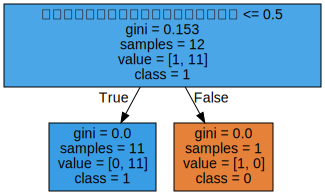

----------------------------------------------------------------------------------------------------
Filter 聲因8 == 1 len = 54
----------------------------------------------------------------------------------------------------
x ['法院是否認為原監護輔助人「身體不堪負荷」', '法院是否認為原監護輔助人「盜領存款」', '法院是否認為原監護輔助人「不當處理本人之不動產」', '法院是否認為原監護輔助人「與本人有利害關係」', '法院是否認為原監護輔助人有「其他不當行為」', '法院是否認為原監護輔助人是「本人之實際照顧者」', '法院是否認為監護人現為本人廣義照顧者', '原監護輔助人是否有意願續任', '專業人士訪視報告之「改定建議」', '本人之「改定建議」', '其他親屬、關係人之「改定建議」']
y 原監護輔助人是否被法院改定
預測 [1 1 1 1 0 1 1 1 1 1 1]
標準答案 [1 1 0 0 0 1 1 1 0 1 1]
績效 0.7272727272727273
|--- feature_7 <= 0.50
|   |--- feature_10 <= 0.50
|   |   |--- class: 1
|   |--- feature_10 >  0.50
|   |   |--- class: 1
|--- feature_7 >  0.50
|   |--- feature_9 <= 0.50
|   |   |--- class: 0
|   |--- feature_9 >  0.50
|   |   |--- class: 1



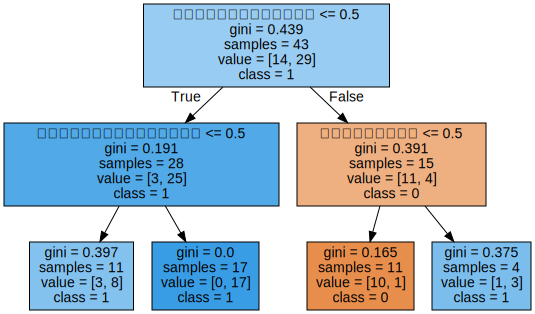

----------------------------------------------------------------------------------------------------
Filter 聲因9 == 1 len = 13
----------------------------------------------------------------------------------------------------
x ['法院是否認為原監護輔助人「身體不堪負荷」', '法院是否認為原監護輔助人「盜領存款」', '法院是否認為原監護輔助人「不當處理本人之不動產」', '法院是否認為原監護輔助人「與本人有利害關係」', '法院是否認為原監護輔助人有「其他不當行為」', '法院是否認為原監護輔助人是「本人之實際照顧者」', '法院是否認為監護人現為本人廣義照顧者', '原監護輔助人是否有意願續任', '專業人士訪視報告之「改定建議」', '本人之「改定建議」', '其他親屬、關係人之「改定建議」']
y 原監護輔助人是否被法院改定
預測 [1 1 1]
標準答案 [1 1 1]
績效 1.0
|--- feature_7 <= 0.50
|   |--- feature_10 <= 0.50
|   |   |--- class: 1
|   |--- feature_10 >  0.50
|   |   |--- class: 1
|--- feature_7 >  0.50
|   |--- class: 0



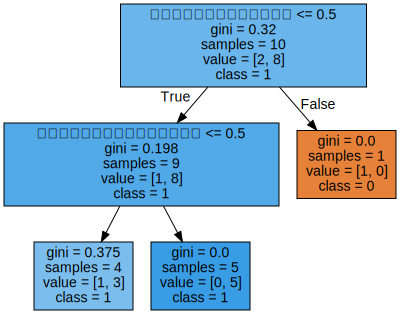

In [47]:
from IPython.display import display

def filter_tree(query):
  p = DecisionTree(gsheet_id, gsheet_name, auto_proc=True, to_drop=[
    'index',
    'UUID',
    '主管機關是否被法院改定 (1=是, 2=否)',
    '宣告性質',
    '原監護輔助人之類型'
  ])
  for col in p.df.columns:
    p.replace_col_to(col, '', 0) # 替換 '' to 0 因為決策樹不支援 NaN
  p.convert_to_numeric()
  p.df = p.df.query(query)
  p.df = p.df.reset_index(drop=True)
  print('-'*100)
  print(f"Filter {query} len = {len(p.df)}")
  print('-'*100)
  p.load(p.cols()[13:24], p.cols()[24], binary_y=True)
  p.text_representation()
  display(p.graph())

for i in range(1, 10):
  filter_tree(f"聲因{str(i)} == 1")


## 8.3.3 決策樹 Filter 聲因 3,4

----------------------------------------------------------------------------------------------------
Filter 聲因3 == 1 | 聲因4 == 1 len = 28
----------------------------------------------------------------------------------------------------
x ['法院是否認為原監護輔助人「身體不堪負荷」', '法院是否認為原監護輔助人「盜領存款」', '法院是否認為原監護輔助人「不當處理本人之不動產」', '法院是否認為原監護輔助人「與本人有利害關係」', '法院是否認為原監護輔助人有「其他不當行為」', '法院是否認為原監護輔助人是「本人之實際照顧者」', '法院是否認為監護人現為本人廣義照顧者', '原監護輔助人是否有意願續任', '專業人士訪視報告之「改定建議」', '本人之「改定建議」', '其他親屬、關係人之「改定建議」']
y 原監護輔助人是否被法院改定
預測 [1 1 0 1 0 0]
標準答案 [1 1 0 1 0 1]
績效 0.8333333333333334
|--- feature_3 <= 0.50
|   |--- feature_4 <= 0.50
|   |   |--- class: 0
|   |--- feature_4 >  0.50
|   |   |--- class: 1
|--- feature_3 >  0.50
|   |--- class: 1



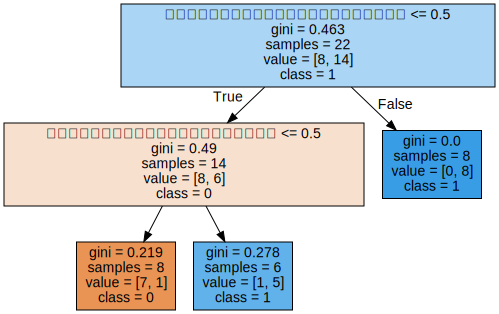

In [48]:
filter_tree("聲因3 == 1 | 聲因4 == 1")

## 8.3.4 決策樹 Filter 聲因 5,6

----------------------------------------------------------------------------------------------------
Filter 聲因5 == 1 | 聲因6 == 1 len = 40
----------------------------------------------------------------------------------------------------
x ['法院是否認為原監護輔助人「身體不堪負荷」', '法院是否認為原監護輔助人「盜領存款」', '法院是否認為原監護輔助人「不當處理本人之不動產」', '法院是否認為原監護輔助人「與本人有利害關係」', '法院是否認為原監護輔助人有「其他不當行為」', '法院是否認為原監護輔助人是「本人之實際照顧者」', '法院是否認為監護人現為本人廣義照顧者', '原監護輔助人是否有意願續任', '專業人士訪視報告之「改定建議」', '本人之「改定建議」', '其他親屬、關係人之「改定建議」']
y 原監護輔助人是否被法院改定
預測 [1 1 1 0 0 1 1 1]
標準答案 [1 1 1 0 1 1 1 1]
績效 0.875
|--- feature_9 <= 0.50
|   |--- feature_7 <= 0.50
|   |   |--- class: 1
|   |--- feature_7 >  0.50
|   |   |--- class: 0
|--- feature_9 >  0.50
|   |--- feature_8 <= 0.50
|   |   |--- class: 1
|   |--- feature_8 >  0.50
|   |   |--- class: 1



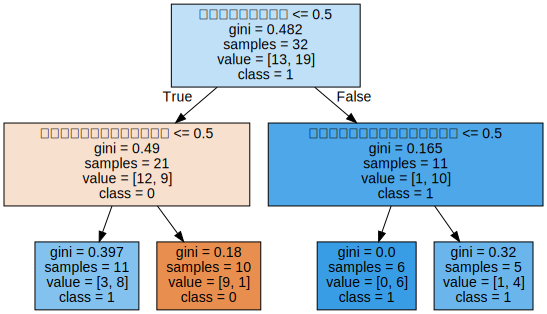

In [49]:
filter_tree("聲因5 == 1 | 聲因6 == 1")

## 8.3.5 決策樹 Filter 聲因 1,2,9

----------------------------------------------------------------------------------------------------
Filter 聲因1 == 1 | 聲因2 == 1 | 聲因9 == 1 len = 34
----------------------------------------------------------------------------------------------------
x ['法院是否認為原監護輔助人「身體不堪負荷」', '法院是否認為原監護輔助人「盜領存款」', '法院是否認為原監護輔助人「不當處理本人之不動產」', '法院是否認為原監護輔助人「與本人有利害關係」', '法院是否認為原監護輔助人有「其他不當行為」', '法院是否認為原監護輔助人是「本人之實際照顧者」', '法院是否認為監護人現為本人廣義照顧者', '原監護輔助人是否有意願續任', '專業人士訪視報告之「改定建議」', '本人之「改定建議」', '其他親屬、關係人之「改定建議」']
y 原監護輔助人是否被法院改定
預測 [1 0 1 0 1 1 1]
標準答案 [1 0 1 1 1 1 1]
績效 0.8571428571428571
|--- feature_7 <= 0.50
|   |--- feature_10 <= 0.50
|   |   |--- class: 1
|   |--- feature_10 >  0.50
|   |   |--- class: 1
|--- feature_7 >  0.50
|   |--- class: 0



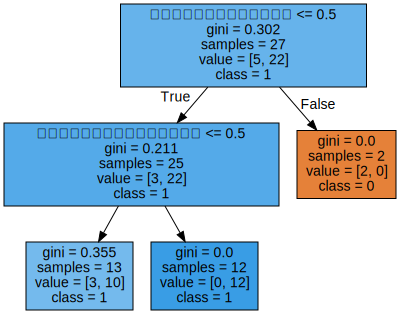

In [50]:
filter_tree("聲因1 == 1 | 聲因2 == 1 | 聲因9 == 1")

## 8.3.6 All 0

----------------------------------------------------------------------------------------------------
Filter 聲因1 == 0 & 聲因2 == 0 & 聲因3 == 0 & 聲因4 == 0 & 聲因5 == 0 & 聲因6 == 0 & 聲因7 == 0 & 聲因8 == 0 & 聲因9 == 0 len = 10
----------------------------------------------------------------------------------------------------
x ['法院是否認為原監護輔助人「身體不堪負荷」', '法院是否認為原監護輔助人「盜領存款」', '法院是否認為原監護輔助人「不當處理本人之不動產」', '法院是否認為原監護輔助人「與本人有利害關係」', '法院是否認為原監護輔助人有「其他不當行為」', '法院是否認為原監護輔助人是「本人之實際照顧者」', '法院是否認為監護人現為本人廣義照顧者', '原監護輔助人是否有意願續任', '專業人士訪視報告之「改定建議」', '本人之「改定建議」', '其他親屬、關係人之「改定建議」']
y 原監護輔助人是否被法院改定
預測 [0 0]
標準答案 [0 0]
績效 1.0
|--- feature_5 <= 0.50
|   |--- class: 0
|--- feature_5 >  0.50
|   |--- feature_6 <= 0.50
|   |   |--- class: 0
|   |--- feature_6 >  0.50
|   |   |--- class: 0



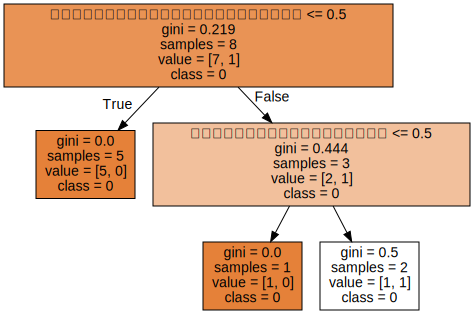

In [51]:
filter_tree("聲因1 == 0 & 聲因2 == 0 & 聲因3 == 0 & 聲因4 == 0 & 聲因5 == 0 & 聲因6 == 0 & 聲因7 == 0 & 聲因8 == 0 & 聲因9 == 0")

## 8.4 所有共線


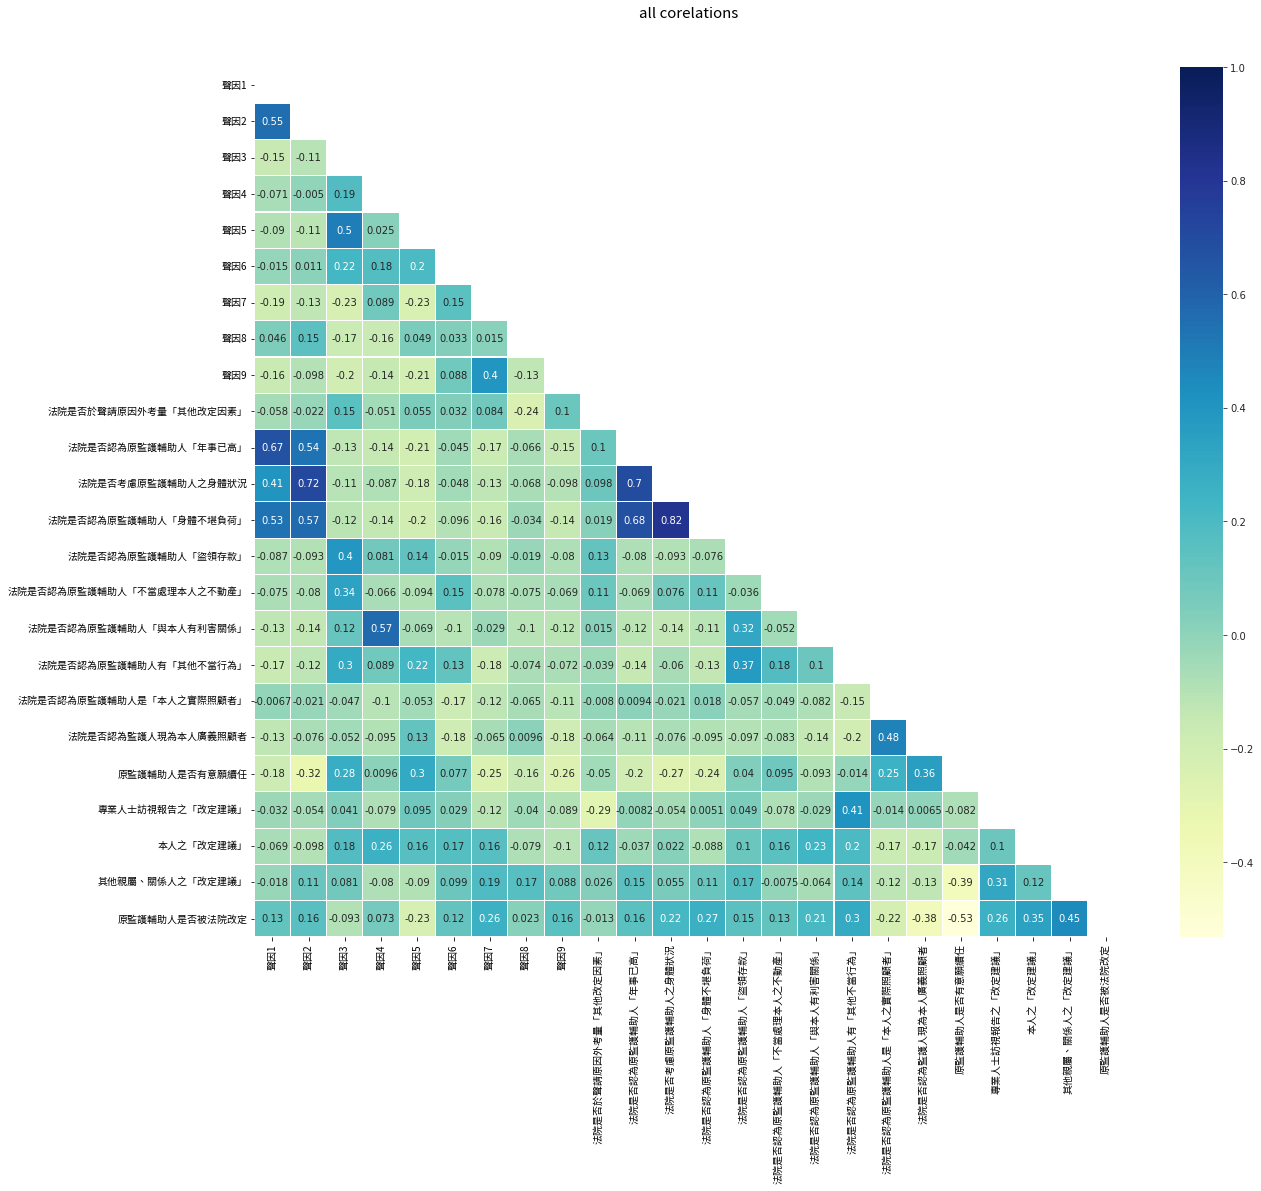

In [26]:
cc = Corr(gsheet_id, gsheet_name, to_drop=[
  'index',
  'UUID',
  #'聲因1',
  #'聲因2',
  #'聲因3',
  #'聲因4',
  #'聲因5',
  #'聲因6',
  #'聲因7',
  #'聲因8',
  #'聲因9',
  '宣告性質',
  '原監護輔助人之類型',
  '原監護輔助人之人數（自然人）',
  '主管機關是否被法院改定 (1=是, 2=否)',
  #'法院是否於聲請原因外考量「其他改定因素」',
  #'法院是否認為原監護輔助人「年事已高」',
  #'法院是否考慮原監護輔助人之身體狀況',
  #'法院是否認為原監護輔助人「身體不堪負荷」',
  #'法院是否認為原監護輔助人「盜領存款」',
  #'法院是否認為原監護輔助人「不當處理本人之不動產」',
  #'原監護輔助人是否與本人有「利害關係」',
  #'法院是否認為原監護輔助人有「其他不當行為」',
  #'法院是否認為原監護輔助人是「本人之實際照顧者」',
  #'監護輔助人是否為本人「廣義照顧者」',
  #'原監護輔助人是否有意願續任',
  #'專業人士訪視報告之「改定建議」',
  #'本人之「改定建議」',
  #'其他親屬、關係人之「改定建議」',
  #'原監護輔助人是否被法院改定',
])
for col in cc.df.columns:
  cc.replace_col_to(col, '', 0)
cc.convert_to_numeric()
cc.corr_heatmap()